In [1]:
import pandas as pd
import numpy as np
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Growth memory enabled")
except:
    print("Invalid device or cannot modify virtual devices once initialized.")
    pass
from tensorflow.keras import layers
from keras_segmentation.models.unet import resnet50_unet
from tensorflow.keras.metrics import MeanIoU
from keras_segmentation.models.unet import vgg_unet
from keras.models import Model
from keras.layers import (
    Input,
    Conv2D,
    Dropout,
    MaxPooling2D,
    UpSampling2D,
    Activation,
    concatenate,
    Reshape,
    Permute,
    Conv2DTranspose,
)
from types import MethodType
from keras.layers import BatchNormalization
from tensorflow.keras.callbacks import (
    TensorBoard,
    ModelCheckpoint,
    EarlyStopping,
    Callback,
)
import datetime
import segmentation_models as sm
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
import albumentations as A
import cv2
import absl.logging

absl.logging.set_verbosity(absl.logging.ERROR)

Growth memory enabled
Segmentation Models: using `keras` framework.


In [2]:
class CityscapesGenerator(tf.keras.utils.Sequence):
    """
    Générateur de données pour le jeu de données Cityscapes, utilisé pour l'entraînement des modèles.

    Args:
        root_dir (str): Chemin du répertoire racine où se trouvent les données Cityscapes.
        batch_size (int): Taille du batch pour le traitement des données.
        img_size (tuple, optional): Dimensions des images (largeur, hauteur). Par défaut à (256, 256).
        data_cat (str, optional): Catégorie des données à utiliser ('train', 'val' ou 'test'). Par défaut à 'train'.
        shuffle (bool, optional): Indique si les données doivent être mélangées à chaque époque. Par défaut à True.
        data_augmentation (bool, optional): Indique si l'augmentation des données doit être appliquée. Par défaut à False.

    Attributes:
        img_size (tuple): Dimensions des images.
        batch_size (int): Taille du batch.
        shuffle (bool): Indicateur de mélange des données.
        img_root (str): Chemin du répertoire contenant les images.
        label_root (str): Chemin du répertoire contenant les étiquettes.
        list_IDs (list): Liste des chemins vers les images.
        labels (dict): Dictionnaire associant les chemins des images à leurs étiquettes.
        categories (dict): Dictionnaire des catégories d'objets dans les étiquettes.
        data_augmentation (bool): Indicateur d'augmentation des données.
        augmentor (albumentations.Compose): Pipeline d'augmentation des données (si activé).
        indexes (np.ndarray): Index des images à utiliser pour chaque batch.

    Return:
        Objet de la classe CityscapesGenerator.
    """
    def __init__(
        self,
        root_dir,
        batch_size,
        img_size=(256, 256),
        data_cat="train",
        shuffle=True,
        data_augmentation=False,
    ):
        "Initialization"
        self.img_size = img_size
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.img_root = os.path.join(
            root_dir, f"P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/{data_cat}"
        )
        self.label_root = os.path.join(
            root_dir, f"P8_Cityscapes_gtFine_trainvaltest/gtFine/{data_cat}"
        )

        # Create full paths for images and labels
        cities = os.listdir(self.img_root)
        self.list_IDs = []  # Will replace the img_paths in your original class
        self.labels = {}  # Using dictionary to store labels against image paths

        for city in cities:
            img_dir = os.path.join(self.img_root, city)
            label_dir = os.path.join(self.label_root, city)

            img_names = sorted(
                [name for name in os.listdir(img_dir) if "_leftImg8bit.png" in name]
            )
            label_names = sorted(
                [
                    name.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
                    for name in img_names
                ]
            )

            self.list_IDs.extend([os.path.join(img_dir, name) for name in img_names])
            for i, name in enumerate(img_names):
                self.labels[os.path.join(img_dir, name)] = os.path.join(
                    label_dir, label_names[i]
                )

        self.categories = {
            "void": [0, 1, 2, 3, 4, 5, 6],
            "flat": [7, 8, 9, 10],
            "construction": [11, 12, 13, 14, 15, 16],
            "object": [17, 18, 19, 20],
            "nature": [21, 22],
            "sky": [23],
            "human": [24, 25],
            "vehicle": [26, 27, 28, 29, 30, 31, 32, 33, -1],
        }

        self.data_augmentation = data_augmentation
        if self.data_augmentation:
            self.augmentor = A.Compose(
                [
                    A.HorizontalFlip(p=0.5),
                    A.ColorJitter(
                        brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5
                    ),
                    A.Blur(blur_limit=2, p=0.3),
                ]
            )

        self.on_epoch_end()

    def __len__(self):
        "Denotes the number of batches per epoch"
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        "Generate one batch of data"
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        "Updates indexes after each epoch"
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        "Generates data containing batch_size samples"
        X = np.empty((self.batch_size, *self.img_size, 3))
        y = np.empty((self.batch_size, *self.img_size, len(self.categories)))

        for i, ID in enumerate(list_IDs_temp):
            # Loading and processing image
            img = Image.open(ID).resize(self.img_size)
            label_img = Image.open(self.labels[ID]).resize(
                self.img_size, resample=Image.NEAREST
            )

            if self.data_augmentation:
                augmented = self.augmentor(
                    image=np.array(img), mask=np.array(label_img)
                )
                img = Image.fromarray((augmented["image"]).astype(np.uint8))
                label_img = Image.fromarray(augmented["mask"])

            label = np.array(label_img)
            X[i,] = np.array(img) / 255.0

            mask = np.zeros((*label.shape, len(self.categories)))
            for k, (cat_name, cat_ids) in enumerate(self.categories.items()):
                for cat_id in cat_ids:
                    mask[:, :, k] = np.logical_or(mask[:, :, k], (label == cat_id))

            y[i] = mask

        return X, y

    def compute_class_weights(self):
        "Computes the weights for each class based on the training data and normalize"
        pixel_counts = np.zeros(len(self.categories))
        total_pixels = 0

        # We loop through the data as you do in your __data_generation function
        for ID in self.list_IDs:
            label_img = Image.open(self.labels[ID]).resize(
                self.img_size, resample=Image.NEAREST
            )
            label = np.array(label_img)

            for k, (cat_name, cat_ids) in enumerate(self.categories.items()):
                for cat_id in cat_ids:
                    pixel_counts[k] += np.sum(label == cat_id)
            total_pixels += label.size  # Total number of pixels in the image

        class_weights = total_pixels / (len(self.categories) * pixel_counts)
        class_weights = class_weights / np.sum(class_weights)

        return class_weights

    def sample_data(self, num_samples=20, output_dir="static/api_sample"):
        """
        Save a sample of the data to the given directory.
        """
        # Create the output directory if it does not exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Randomly select `num_samples` images
        sample_images = random.sample(self.list_IDs, num_samples)

        for img_path in sample_images:
            # Get the associated label path
            label_path = self.labels[img_path]

            # Load the image and label
            img = Image.open(img_path)
            label_img = Image.open(label_path)
            label = np.array(label_img)

            # Remap the label
            remapped_label = np.zeros(label.shape)
            for k, (cat_name, cat_ids) in enumerate(self.categories.items()):
                for cat_id in cat_ids:
                    remapped_label = np.where(label == cat_id, k, remapped_label)

            # Convert remapped_label back to image
            remapped_label_img = Image.fromarray(remapped_label.astype(np.uint8))

            # Define the save paths
            img_save_path = os.path.join(output_dir, os.path.basename(img_path))
            label_save_path = os.path.join(output_dir, os.path.basename(label_path))

            # Save the image and label
            img.save(img_save_path)
            remapped_label_img.save(label_save_path)

In [3]:
class VisualizeCallback(Callback):
    """
    Callback personnalisé pour la visualisation des résultats de segmentation pendant l'entraînement d'un modèle de deep learning.

    Args:
        generator (tf.keras.utils.Sequence): Générateur fournissant les données et les étiquettes pour la visualisation.
        model_name (str): Nom du modèle utilisé pour distinguer les sorties enregistrées.
        sample_index (int, optional): Index de l'échantillon à visualiser. Par défaut à 15.
        output_dir (str, optional): Répertoire de base pour enregistrer les images générées. Par défaut à "training_img".
        log_dir (str, optional): Répertoire pour enregistrer les logs TensorBoard. Si None, les logs ne sont pas enregistrés. Par défaut à None.

    Attributes:
        generator (tf.keras.utils.Sequence): Générateur utilisé pour la visualisation.
        sample_index (int): Index de l'échantillon sélectionné pour la visualisation.
        output_dir (str): Chemin du répertoire de sortie pour les images générées.
        log_dir (str): Chemin du répertoire pour les logs TensorBoard.
        file_writer (tf.summary.FileWriter): Écrivain de fichier pour TensorBoard.

    Méthodes:
        on_epoch_end: Appelé à la fin de chaque époque pour générer et enregistrer une image de visualisation.
    """
    def __init__(
        self,
        generator,
        model_name,
        sample_index=15,
        output_dir="training_img",
        log_dir=None,
    ):
        super(VisualizeCallback, self).__init__()

        self.generator = generator
        self.sample_index = sample_index
        self.output_dir = os.path.join(output_dir, model_name)
        self.log_dir = log_dir

        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        if log_dir:
            self.file_writer = tf.summary.create_file_writer(log_dir)

    def on_epoch_end(self, epoch, logs=None):
        print(f"\nGenerating output at epoch : {epoch}")
        # Retrieve the image and mask using the generator's __getitem__ method
        img, mask_true = self.generator[self.sample_index]
        img = img[
            0
        ]  # Since the generator returns batches, we just want the first image in the batch
        dims = img.shape
        z = self.model.predict(tf.expand_dims(img, axis=0))
        z = tf.squeeze(z)

        if z.shape[-1] != len(self.generator.categories):
            raise ValueError(
                "The last dimension of the model's output should be the number of categories."
            )

        z = tf.image.resize(z, (dims[1], dims[0]))
        y = tf.argmax(z, axis=-1)

        # Define masks
        nature = np.zeros_like(y)
        human = np.zeros_like(y)
        flat = np.zeros_like(y)
        nature[y == 4] = 255.0
        human[y == 6] = 255.0
        flat[y == 1] = 255.0

        result = img.copy()
        alpha = 0.4
        result[:, :, 1] = nature
        result[:, :, 2] = flat
        result[:, :, 0] = human

        final_output = np.zeros_like(result)
        cv2.addWeighted(result, alpha, img, 1 - alpha, 0, final_output)
        final_output = (final_output * 255).astype(np.uint8)

        # Save image to disk
        cv2.imwrite(
            os.path.join(self.output_dir, f"{epoch}.png"),
            cv2.cvtColor(final_output, cv2.COLOR_RGB2BGR),
        )

        # If log_dir is specified, write the image into TensorBoard
        if self.log_dir:
            with self.file_writer.as_default():
                tf.summary.image(
                    "Visualize Image", tf.expand_dims(final_output, 0), step=epoch
                )

        print("Wrote file to disk")

In [4]:
root_dir = "data"
batch_size = 16

train_gen = CityscapesGenerator(root_dir, batch_size)
# train_gen.sample_data()
train_gen_aug = CityscapesGenerator(root_dir, batch_size, data_augmentation=True)
class_weights = train_gen.compute_class_weights()
val_gen = CityscapesGenerator(root_dir, batch_size, data_cat="val")

In [5]:
def count_gen(gen, cat):
    num_images = len(gen.list_IDs)
    print(f"{cat}")
    print(f"Nombre total d'images dans le générateur: {num_images}")


count_gen(train_gen, "Set d'entrainement:")
count_gen(val_gen, "Set de validation:")

Set d'entrainement:
Nombre total d'images dans le générateur: 2975
Set de validation:
Nombre total d'images dans le générateur: 500


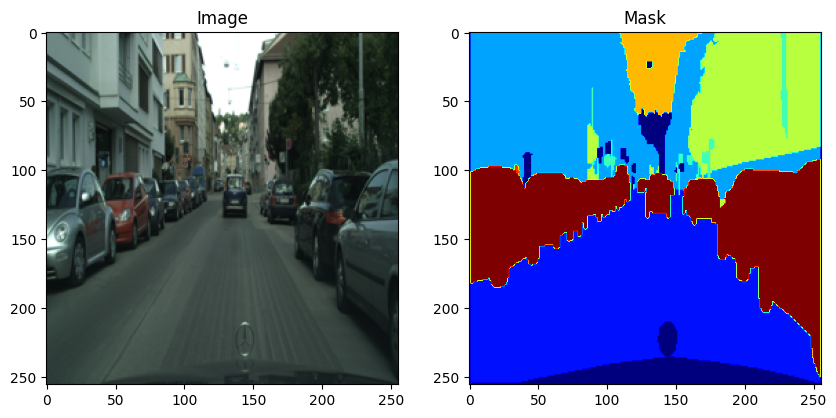

In [5]:
def plot_img_mask(generator):
    """
    Cette fonction récupère le premier lot du générateur fourni, extrait la première image et son masque 
    correspondant, et affiche l'image et le masque côte à côte pour comparaison.

    Args:
        generator (tf.keras.utils.Sequence): Générateur fournissant des lots d'images et de masques.
    """
    batch_imgs, batch_labels = generator[0]
    sample_img = batch_imgs[0]
    sample_label = batch_labels[0]
    img_sample = np.argmax(sample_label, axis=-1)
    plt.figure(figsize=(10, 5))

    # Afficher l'image
    plt.subplot(1, 2, 1)
    plt.imshow(sample_img)
    plt.title("Image")

    # Afficher le masque
    plt.subplot(1, 2, 2)
    plt.imshow(img_sample, cmap="jet")
    plt.title("Mask")
    plt.show()


plot_img_mask(train_gen)

#### Visualisation Data augmentation (flou de mouvement et horizontal flip)

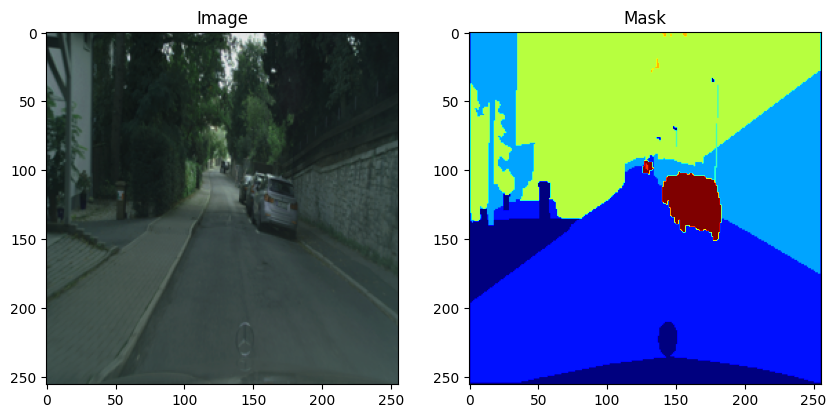

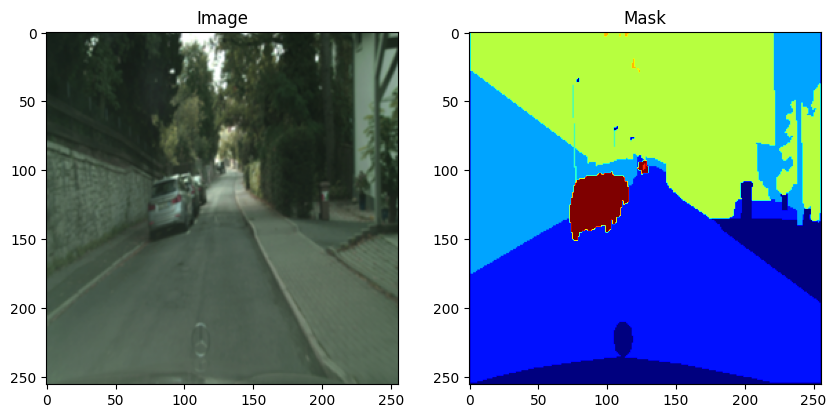

In [6]:
plot_img_mask(train_gen_aug)
plot_img_mask(train_gen_aug)

### Unet
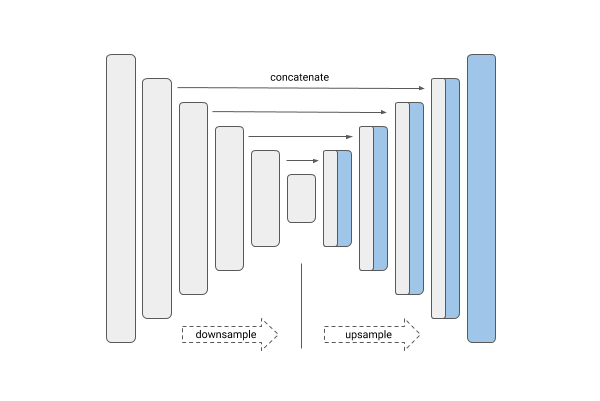

In [5]:
jaccard_index = sm.metrics.IOUScore()
dice_coef = sm.metrics.FScore(beta=1)
dice_loss = sm.losses.DiceLoss(class_weights=class_weights)
tf.keras.backend.set_image_data_format("channels_last")

In [6]:
class_weights

array([0.04681816, 0.01256017, 0.02227352, 0.27617385, 0.03223511,
       0.13659585, 0.40692867, 0.06641466])

In [6]:
def plot_history(history):
    """
    Cette fonction dessine deux graphiques : un pour la perte d'entraînement et de validation, 
    et un autre pour l'IOU score d'entraînement et de validation, à travers les différentes époques.

    Args:
        history (tf.keras.callbacks.History): Historique d'apprentissage d'un modèle, contenant les métriques 
        de performance par époque pendant l'entraînement.
    """
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Courbe d'apprentissage pour la perte")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Afficher la courbe d'apprentissage pour le Dice coefficient
    plt.subplot(1, 2, 2)
    plt.plot(history.history["iou_score"], label="Train IOU score")
    plt.plot(history.history["val_iou_score"], label="Validation IOU score")
    plt.title("Courbe d'apprentissage pour le IOU score")
    plt.xlabel("Epochs")
    plt.ylabel("Intersection Over Union")
    plt.legend()

    plt.tight_layout()
    plt.show()

### Unet_mini (modèle de référence)

In [7]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    Construit un bloc encodeur pour le modèle U-Net.

    Args:
        inputs (tf.Tensor): Entrée du bloc encodeur.
        n_filters (int, optional): Nombre de filtres pour les couches convolutives. Par défaut à 32.
        dropout_prob (float, optional): Probabilité de dropout. Par défaut à 0.3.
        max_pooling (bool, optional): Indique si une couche de max pooling doit être incluse. Par défaut à True.

    Returns:
        Tuple[tf.Tensor, tf.Tensor]: Le prochain niveau de couche après le max pooling et la connexion 
        à sauter pour le bloc décodeur correspondant.
    """
    conv = Conv2D(
        n_filters,
        3,  # filter size
        activation="relu",
        padding="same",
        kernel_initializer="HeNormal",
    )(inputs)
    conv = Conv2D(
        n_filters,
        3,  # filter size
        activation="relu",
        padding="same",
        kernel_initializer="HeNormal",
    )(conv)

    conv = BatchNormalization()(conv, training=False)
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)
    else:
        next_layer = conv
    skip_connection = conv
    return next_layer, skip_connection


def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Construit un bloc décodeur pour le modèle U-Net.

    Args:
        prev_layer_input (tf.Tensor): Entrée du bloc décodeur (provenant de la couche précédente).
        skip_layer_input (tf.Tensor): Entrée de la connexion à sauter (provenant du bloc encodeur correspondant).
        n_filters (int, optional): Nombre de filtres pour les couches convolutives. Par défaut à 32.

    Returns:
        tf.Tensor: Sortie du bloc décodeur.
    """
    up = Conv2DTranspose(n_filters, (3, 3), strides=(2, 2), padding="same")(
        prev_layer_input
    )
    merge = concatenate([up, skip_layer_input], axis=3)
    conv = Conv2D(
        n_filters, 3, activation="relu", padding="same", kernel_initializer="HeNormal"
    )(merge)
    conv = Conv2D(
        n_filters, 3, activation="relu", padding="same", kernel_initializer="HeNormal"
    )(conv)
    return conv


def Unet_mini(input_size=(256, 256, 3)):
    """
    Construit un modèle U-Net simplifié.

    Args:
        input_size (tuple, optional): Taille des images d'entrée. Par défaut à (256, 256, 3).

    Returns:
        tf.keras.Model: Modèle U-Net simplifié construit à partir des blocs encodeurs et décodeurs définis.
    """
    inputs = Input(shape=input_size)
    enc1, skip1 = EncoderMiniBlock(inputs, n_filters=32)
    enc2, skip2 = EncoderMiniBlock(enc1, n_filters=64)
    bottleneck = Conv2D(
        128, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(enc2)
    dec2 = DecoderMiniBlock(bottleneck, skip2, n_filters=64)
    dec1 = DecoderMiniBlock(dec2, skip1, n_filters=32)
    outputs = Conv2D(len(train_gen.categories), 1, activation="softmax")(dec1)
    unet_mini = Model(inputs=inputs, outputs=outputs)
    return unet_mini

### Unet mini 

Epoch 1/30
87/87 [==============================] - ETA: 0s - loss: 0.9827 - iou_score: 0.1336 - f1-score: 0.2009INFO:tensorflow:Assets written to: saved_model\unet_mini\assets


INFO:tensorflow:Assets written to: saved_model\unet_mini\assets



Generating output at epoch : 0
1/1 [==============================] - 1s 632ms/step
Wrote file to disk
87/87 [==============================] - 252s 3s/step - loss: 0.9827 - iou_score: 0.1336 - f1-score: 0.2009 - val_loss: 0.9757 - val_iou_score: 0.2091 - val_f1-score: 0.3035
Epoch 2/30
87/87 [==============================] - ETA: 0s - loss: 0.9700 - iou_score: 0.2591 - f1-score: 0.3586INFO:tensorflow:Assets written to: saved_model\unet_mini\assets


INFO:tensorflow:Assets written to: saved_model\unet_mini\assets



Generating output at epoch : 1
1/1 [==============================] - 0s 17ms/step
Wrote file to disk
87/87 [==============================] - 243s 3s/step - loss: 0.9700 - iou_score: 0.2591 - f1-score: 0.3586 - val_loss: 0.9685 - val_iou_score: 0.2471 - val_f1-score: 0.3637
Epoch 3/30
87/87 [==============================] - ETA: 0s - loss: 0.9665 - iou_score: 0.2975 - f1-score: 0.4037INFO:tensorflow:Assets written to: saved_model\unet_mini\assets


INFO:tensorflow:Assets written to: saved_model\unet_mini\assets



Generating output at epoch : 2
1/1 [==============================] - 0s 16ms/step
Wrote file to disk
87/87 [==============================] - 238s 3s/step - loss: 0.9665 - iou_score: 0.2975 - f1-score: 0.4037 - val_loss: 0.9654 - val_iou_score: 0.2806 - val_f1-score: 0.3946
Epoch 4/30
87/87 [==============================] - ETA: 0s - loss: 0.9622 - iou_score: 0.3141 - f1-score: 0.4259
Generating output at epoch : 3
1/1 [==============================] - 0s 18ms/step
Wrote file to disk
87/87 [==============================] - 238s 3s/step - loss: 0.9622 - iou_score: 0.3141 - f1-score: 0.4259 - val_loss: 0.9760 - val_iou_score: 0.2685 - val_f1-score: 0.3731
Epoch 5/30
87/87 [==============================] - ETA: 0s - loss: 0.9724 - iou_score: 0.3193 - f1-score: 0.4215INFO:tensorflow:Assets written to: saved_model\unet_mini\assets


INFO:tensorflow:Assets written to: saved_model\unet_mini\assets



Generating output at epoch : 4
1/1 [==============================] - 0s 16ms/step
Wrote file to disk
87/87 [==============================] - 240s 3s/step - loss: 0.9724 - iou_score: 0.3193 - f1-score: 0.4215 - val_loss: 0.9730 - val_iou_score: 0.3003 - val_f1-score: 0.4096
Epoch 6/30
87/87 [==============================] - ETA: 0s - loss: 0.9567 - iou_score: 0.3496 - f1-score: 0.4699
Generating output at epoch : 5
1/1 [==============================] - 0s 18ms/step
Wrote file to disk
87/87 [==============================] - 236s 3s/step - loss: 0.9567 - iou_score: 0.3496 - f1-score: 0.4699 - val_loss: 0.9656 - val_iou_score: 0.2797 - val_f1-score: 0.4067
Epoch 7/30
87/87 [==============================] - ETA: 0s - loss: 0.9511 - iou_score: 0.3830 - f1-score: 0.5120INFO:tensorflow:Assets written to: saved_model\unet_mini\assets


INFO:tensorflow:Assets written to: saved_model\unet_mini\assets



Generating output at epoch : 6
1/1 [==============================] - 0s 16ms/step
Wrote file to disk
87/87 [==============================] - 237s 3s/step - loss: 0.9511 - iou_score: 0.3830 - f1-score: 0.5120 - val_loss: 0.9510 - val_iou_score: 0.3675 - val_f1-score: 0.4991
Epoch 8/30
87/87 [==============================] - ETA: 0s - loss: 0.9481 - iou_score: 0.4014 - f1-score: 0.5314INFO:tensorflow:Assets written to: saved_model\unet_mini\assets


INFO:tensorflow:Assets written to: saved_model\unet_mini\assets



Generating output at epoch : 7
1/1 [==============================] - 0s 16ms/step
Wrote file to disk
87/87 [==============================] - 240s 3s/step - loss: 0.9481 - iou_score: 0.4014 - f1-score: 0.5314 - val_loss: 0.9478 - val_iou_score: 0.3760 - val_f1-score: 0.5127
Epoch 9/30
87/87 [==============================] - ETA: 0s - loss: 0.9448 - iou_score: 0.4180 - f1-score: 0.5497
Generating output at epoch : 8
1/1 [==============================] - 0s 17ms/step
Wrote file to disk
87/87 [==============================] - 240s 3s/step - loss: 0.9448 - iou_score: 0.4180 - f1-score: 0.5497 - val_loss: 0.9545 - val_iou_score: 0.3577 - val_f1-score: 0.4906
Epoch 10/30
87/87 [==============================] - ETA: 0s - loss: 0.9441 - iou_score: 0.4222 - f1-score: 0.5545
Generating output at epoch : 9
1/1 [==============================] - 0s 18ms/step
Wrote file to disk
87/87 [==============================] - 235s 3s/step - loss: 0.9441 - iou_score: 0.4222 - f1-score: 0.5545 - val_lo

INFO:tensorflow:Assets written to: saved_model\unet_mini\assets



Generating output at epoch : 10
1/1 [==============================] - 0s 16ms/step
Wrote file to disk
87/87 [==============================] - 236s 3s/step - loss: 0.9420 - iou_score: 0.4349 - f1-score: 0.5678 - val_loss: 0.9450 - val_iou_score: 0.3868 - val_f1-score: 0.5269
Epoch 12/30
87/87 [==============================] - ETA: 0s - loss: 0.9404 - iou_score: 0.4425 - f1-score: 0.5759INFO:tensorflow:Assets written to: saved_model\unet_mini\assets


INFO:tensorflow:Assets written to: saved_model\unet_mini\assets



Generating output at epoch : 11
1/1 [==============================] - 0s 15ms/step
Wrote file to disk
87/87 [==============================] - 237s 3s/step - loss: 0.9404 - iou_score: 0.4425 - f1-score: 0.5759 - val_loss: 0.9422 - val_iou_score: 0.4099 - val_f1-score: 0.5499
Epoch 13/30
87/87 [==============================] - ETA: 0s - loss: 0.9400 - iou_score: 0.4424 - f1-score: 0.5762INFO:tensorflow:Assets written to: saved_model\unet_mini\assets


INFO:tensorflow:Assets written to: saved_model\unet_mini\assets



Generating output at epoch : 12
1/1 [==============================] - 0s 15ms/step
Wrote file to disk
87/87 [==============================] - 240s 3s/step - loss: 0.9400 - iou_score: 0.4424 - f1-score: 0.5762 - val_loss: 0.9434 - val_iou_score: 0.4174 - val_f1-score: 0.5544
Epoch 14/30
87/87 [==============================] - ETA: 0s - loss: 0.9389 - iou_score: 0.4502 - f1-score: 0.5840
Generating output at epoch : 13
1/1 [==============================] - 0s 17ms/step
Wrote file to disk
87/87 [==============================] - 239s 3s/step - loss: 0.9389 - iou_score: 0.4502 - f1-score: 0.5840 - val_loss: 0.9436 - val_iou_score: 0.3927 - val_f1-score: 0.5322
Epoch 15/30
87/87 [==============================] - ETA: 0s - loss: 0.9368 - iou_score: 0.4598 - f1-score: 0.5938INFO:tensorflow:Assets written to: saved_model\unet_mini\assets


INFO:tensorflow:Assets written to: saved_model\unet_mini\assets



Generating output at epoch : 14
1/1 [==============================] - 0s 16ms/step
Wrote file to disk
87/87 [==============================] - 243s 3s/step - loss: 0.9368 - iou_score: 0.4598 - f1-score: 0.5938 - val_loss: 0.9396 - val_iou_score: 0.4322 - val_f1-score: 0.5710
Epoch 16/30
87/87 [==============================] - ETA: 0s - loss: 0.9356 - iou_score: 0.4638 - f1-score: 0.5980
Generating output at epoch : 15
1/1 [==============================] - 0s 18ms/step
Wrote file to disk
87/87 [==============================] - 240s 3s/step - loss: 0.9356 - iou_score: 0.4638 - f1-score: 0.5980 - val_loss: 0.9392 - val_iou_score: 0.4252 - val_f1-score: 0.5674
Epoch 17/30
87/87 [==============================] - ETA: 0s - loss: 0.9347 - iou_score: 0.4717 - f1-score: 0.6055
Generating output at epoch : 16
1/1 [==============================] - 0s 15ms/step
Wrote file to disk
87/87 [==============================] - 239s 3s/step - loss: 0.9347 - iou_score: 0.4717 - f1-score: 0.6055 - va

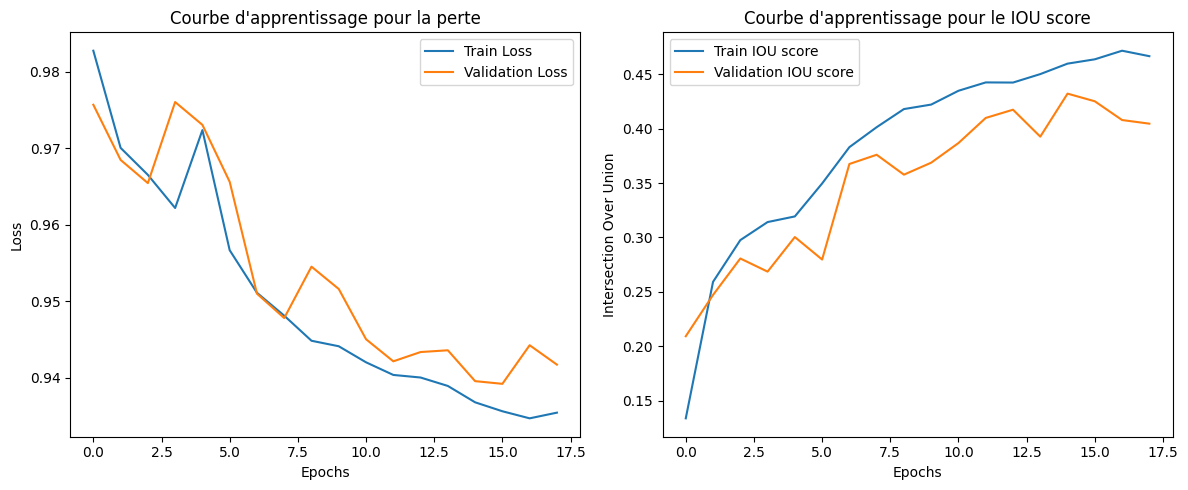

In [8]:
model_name = "_Unet_mini"
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + model_name
visualize_callback = VisualizeCallback(
    generator=train_gen, model_name=model_name, log_dir=log_dir
)
checkpoint_callback = ModelCheckpoint(
    "saved_model/unet_mini", save_best_only=True, monitor="val_iou_score", mode="max"
)
tensorboard_callback = TensorBoard(log_dir=log_dir, write_graph=True, write_images=True)
early_stopping = EarlyStopping(monitor="val_iou_score", patience=3, mode="max")
unet_mini = Unet_mini()
unet_mini.compile(optimizer="adam", loss=dice_loss, metrics=[jaccard_index, dice_coef])
num_epochs = 30
history = unet_mini.fit(
    train_gen,
    epochs=num_epochs,
    validation_data=val_gen,
    callbacks=[
        checkpoint_callback,
        tensorboard_callback,
        early_stopping,
        visualize_callback,
    ],
)
scores = unet_mini.evaluate(val_gen, verbose=0)
print("Loss:", scores[0])
print("IOU score:", scores[1])
print("F1 score:", scores[2])
plot_history(history)

Le modèle Unet-mini que nous avons entrainé ci dessus comme modèle de référence montre des limites de performances.  
Voici la superposition à l'image originale du masque prédit (uniquement pour 3 catégories) à la fin de la dernière époque d'entrainement : 
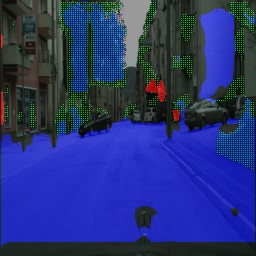  
**PS** :   
Rouge = Human  
         Green = Nature   
         Bleu = Flat  

### Unet - Backbone : resnet50

Epoch 1/30
185/185 [==============================] - ETA: 0s - loss: 0.9490 - iou_score: 0.3603 - f1-score: 0.4868INFO:tensorflow:Assets written to: saved_model\Unet_resnet50\assets


INFO:tensorflow:Assets written to: saved_model\Unet_resnet50\assets



Generating output at epoch : 0
1/1 [==============================] - 1s 693ms/step
Wrote file to disk
185/185 [==============================] - 252s 1s/step - loss: 0.9490 - iou_score: 0.3603 - f1-score: 0.4868 - val_loss: 0.9962 - val_iou_score: 0.0564 - val_f1-score: 0.0972
Epoch 2/30
185/185 [==============================] - ETA: 0s - loss: 0.9277 - iou_score: 0.5814 - f1-score: 0.7121INFO:tensorflow:Assets written to: saved_model\Unet_resnet50\assets


INFO:tensorflow:Assets written to: saved_model\Unet_resnet50\assets



Generating output at epoch : 1
1/1 [==============================] - 0s 20ms/step
Wrote file to disk
185/185 [==============================] - 240s 1s/step - loss: 0.9277 - iou_score: 0.5814 - f1-score: 0.7121 - val_loss: 0.9945 - val_iou_score: 0.1605 - val_f1-score: 0.2209
Epoch 3/30
185/185 [==============================] - ETA: 0s - loss: 0.9227 - iou_score: 0.6180 - f1-score: 0.7433INFO:tensorflow:Assets written to: saved_model\Unet_resnet50\assets


INFO:tensorflow:Assets written to: saved_model\Unet_resnet50\assets



Generating output at epoch : 2
1/1 [==============================] - 0s 20ms/step
Wrote file to disk
185/185 [==============================] - 242s 1s/step - loss: 0.9227 - iou_score: 0.6180 - f1-score: 0.7433 - val_loss: 0.9938 - val_iou_score: 0.1808 - val_f1-score: 0.2411
Epoch 4/30
185/185 [==============================] - ETA: 0s - loss: 0.9186 - iou_score: 0.6440 - f1-score: 0.7652INFO:tensorflow:Assets written to: saved_model\Unet_resnet50\assets


INFO:tensorflow:Assets written to: saved_model\Unet_resnet50\assets



Generating output at epoch : 3
1/1 [==============================] - 0s 20ms/step
Wrote file to disk
185/185 [==============================] - 243s 1s/step - loss: 0.9186 - iou_score: 0.6440 - f1-score: 0.7652 - val_loss: 0.9932 - val_iou_score: 0.1976 - val_f1-score: 0.2588
Epoch 5/30
185/185 [==============================] - ETA: 0s - loss: 0.9146 - iou_score: 0.6717 - f1-score: 0.7875INFO:tensorflow:Assets written to: saved_model\Unet_resnet50\assets


INFO:tensorflow:Assets written to: saved_model\Unet_resnet50\assets



Generating output at epoch : 4
1/1 [==============================] - 0s 20ms/step
Wrote file to disk
185/185 [==============================] - 243s 1s/step - loss: 0.9146 - iou_score: 0.6717 - f1-score: 0.7875 - val_loss: 0.9677 - val_iou_score: 0.3256 - val_f1-score: 0.4270
Epoch 6/30
185/185 [==============================] - ETA: 0s - loss: 0.9139 - iou_score: 0.6797 - f1-score: 0.7938INFO:tensorflow:Assets written to: saved_model\Unet_resnet50\assets


INFO:tensorflow:Assets written to: saved_model\Unet_resnet50\assets



Generating output at epoch : 5
1/1 [==============================] - 0s 20ms/step
Wrote file to disk
185/185 [==============================] - 245s 1s/step - loss: 0.9139 - iou_score: 0.6797 - f1-score: 0.7938 - val_loss: 0.9367 - val_iou_score: 0.4399 - val_f1-score: 0.5746
Epoch 7/30
185/185 [==============================] - ETA: 0s - loss: 0.9126 - iou_score: 0.6863 - f1-score: 0.7991
Generating output at epoch : 6
1/1 [==============================] - 0s 20ms/step
Wrote file to disk
185/185 [==============================] - 232s 1s/step - loss: 0.9126 - iou_score: 0.6863 - f1-score: 0.7991 - val_loss: 0.9400 - val_iou_score: 0.3059 - val_f1-score: 0.4387
Epoch 8/30
185/185 [==============================] - ETA: 0s - loss: 0.9110 - iou_score: 0.6936 - f1-score: 0.8052INFO:tensorflow:Assets written to: saved_model\Unet_resnet50\assets


INFO:tensorflow:Assets written to: saved_model\Unet_resnet50\assets



Generating output at epoch : 7
1/1 [==============================] - 0s 20ms/step
Wrote file to disk
185/185 [==============================] - 248s 1s/step - loss: 0.9110 - iou_score: 0.6936 - f1-score: 0.8052 - val_loss: 0.9230 - val_iou_score: 0.6302 - val_f1-score: 0.7520
Epoch 9/30
185/185 [==============================] - ETA: 0s - loss: 0.9090 - iou_score: 0.7074 - f1-score: 0.8156INFO:tensorflow:Assets written to: saved_model\Unet_resnet50\assets


INFO:tensorflow:Assets written to: saved_model\Unet_resnet50\assets



Generating output at epoch : 8
1/1 [==============================] - 0s 22ms/step
Wrote file to disk
185/185 [==============================] - 248s 1s/step - loss: 0.9090 - iou_score: 0.7074 - f1-score: 0.8156 - val_loss: 0.9161 - val_iou_score: 0.6651 - val_f1-score: 0.7817
Epoch 10/30
185/185 [==============================] - ETA: 0s - loss: 0.9083 - iou_score: 0.7117 - f1-score: 0.8191
Generating output at epoch : 9
1/1 [==============================] - 0s 21ms/step
Wrote file to disk
185/185 [==============================] - 233s 1s/step - loss: 0.9083 - iou_score: 0.7117 - f1-score: 0.8191 - val_loss: 0.9168 - val_iou_score: 0.6567 - val_f1-score: 0.7760
Epoch 11/30
185/185 [==============================] - ETA: 0s - loss: 0.9066 - iou_score: 0.7223 - f1-score: 0.8273
Generating output at epoch : 10
1/1 [==============================] - 0s 21ms/step
Wrote file to disk
185/185 [==============================] - 234s 1s/step - loss: 0.9066 - iou_score: 0.7223 - f1-score: 0.8

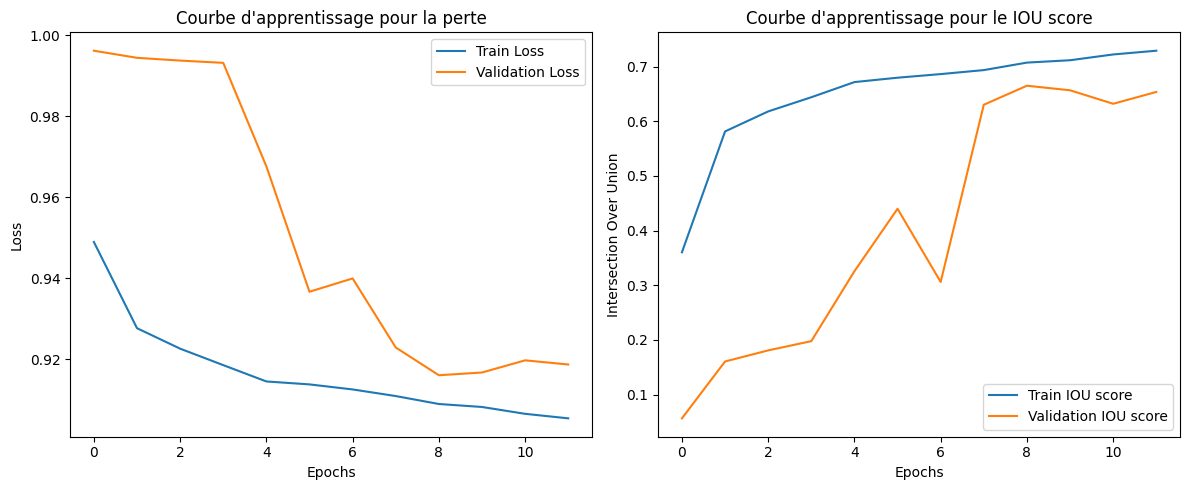

CPU times: total: 39min 41s
Wall time: 48min 51s


In [7]:
%%time
model_name = "_Unet_resnet50"
num_epochs = 30
model = sm.Unet(
    "resnet50",
    input_shape=(256, 256, 3),
    classes=len(train_gen.categories),
    activation="softmax",
)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + model_name
visualize_callback = VisualizeCallback(
    generator=train_gen, model_name=model_name, log_dir=log_dir
)
checkpoint_callback = ModelCheckpoint(
    "saved_model/Unet_resnet50",
    save_best_only=True,
    monitor="val_iou_score",
    mode="max",
)
tensorboard_callback = TensorBoard(log_dir=log_dir, write_graph=True, write_images=True)
early_stopping = EarlyStopping(monitor="val_iou_score", patience=3, mode="max")
model.compile(optimizer="adam", loss=dice_loss, metrics=[jaccard_index, dice_coef])
history = model.fit(
    train_gen,
    epochs=num_epochs,
    validation_data=val_gen,
    callbacks=[
        checkpoint_callback,
        tensorboard_callback,
        early_stopping,
        visualize_callback,
    ],
)
scores = model.evaluate(val_gen, verbose=0)
print("Loss:", scores[0])
print("IOU score:", scores[1])
print("F1 score:", scores[2])
plot_history(history)

### Unet - Backbone : vgg16

Epoch 1/30
185/185 [==============================] - ETA: 0s - loss: 0.9485 - iou_score: 0.3948 - f1-score: 0.5230INFO:tensorflow:Assets written to: saved_model\Unet_vgg16\assets


INFO:tensorflow:Assets written to: saved_model\Unet_vgg16\assets



Generating output at epoch : 0
1/1 [==============================] - 1s 593ms/step
Wrote file to disk
185/185 [==============================] - 248s 1s/step - loss: 0.9485 - iou_score: 0.3948 - f1-score: 0.5230 - val_loss: 0.9643 - val_iou_score: 0.3874 - val_f1-score: 0.5178
Epoch 2/30
185/185 [==============================] - ETA: 0s - loss: 0.9283 - iou_score: 0.5834 - f1-score: 0.7130INFO:tensorflow:Assets written to: saved_model\Unet_vgg16\assets


INFO:tensorflow:Assets written to: saved_model\Unet_vgg16\assets



Generating output at epoch : 1
1/1 [==============================] - 0s 20ms/step
Wrote file to disk
185/185 [==============================] - 238s 1s/step - loss: 0.9283 - iou_score: 0.5834 - f1-score: 0.7130 - val_loss: 0.9331 - val_iou_score: 0.5490 - val_f1-score: 0.6862
Epoch 3/30
185/185 [==============================] - ETA: 0s - loss: 0.9221 - iou_score: 0.6255 - f1-score: 0.7495INFO:tensorflow:Assets written to: saved_model\Unet_vgg16\assets


INFO:tensorflow:Assets written to: saved_model\Unet_vgg16\assets



Generating output at epoch : 2
1/1 [==============================] - 0s 18ms/step
Wrote file to disk
185/185 [==============================] - 237s 1s/step - loss: 0.9221 - iou_score: 0.6255 - f1-score: 0.7495 - val_loss: 0.9330 - val_iou_score: 0.5825 - val_f1-score: 0.7089
Epoch 4/30
185/185 [==============================] - ETA: 0s - loss: 0.9185 - iou_score: 0.6472 - f1-score: 0.7676INFO:tensorflow:Assets written to: saved_model\Unet_vgg16\assets


INFO:tensorflow:Assets written to: saved_model\Unet_vgg16\assets



Generating output at epoch : 3
1/1 [==============================] - 0s 18ms/step
Wrote file to disk
185/185 [==============================] - 237s 1s/step - loss: 0.9185 - iou_score: 0.6472 - f1-score: 0.7676 - val_loss: 0.9224 - val_iou_score: 0.6125 - val_f1-score: 0.7407
Epoch 5/30
185/185 [==============================] - ETA: 0s - loss: 0.9163 - iou_score: 0.6593 - f1-score: 0.7780
Generating output at epoch : 4
1/1 [==============================] - 0s 19ms/step
Wrote file to disk
185/185 [==============================] - 233s 1s/step - loss: 0.9163 - iou_score: 0.6593 - f1-score: 0.7780 - val_loss: 0.9373 - val_iou_score: 0.3940 - val_f1-score: 0.5501
Epoch 6/30
185/185 [==============================] - ETA: 0s - loss: 0.9151 - iou_score: 0.6628 - f1-score: 0.7817
Generating output at epoch : 5
1/1 [==============================] - 0s 17ms/step
Wrote file to disk
185/185 [==============================] - 233s 1s/step - loss: 0.9151 - iou_score: 0.6628 - f1-score: 0.7817

INFO:tensorflow:Assets written to: saved_model\Unet_vgg16\assets



Generating output at epoch : 6
1/1 [==============================] - 0s 17ms/step
Wrote file to disk
185/185 [==============================] - 238s 1s/step - loss: 0.9127 - iou_score: 0.6805 - f1-score: 0.7952 - val_loss: 0.9190 - val_iou_score: 0.6261 - val_f1-score: 0.7539
Epoch 8/30
185/185 [==============================] - ETA: 0s - loss: 0.9098 - iou_score: 0.6980 - f1-score: 0.8091INFO:tensorflow:Assets written to: saved_model\Unet_vgg16\assets


INFO:tensorflow:Assets written to: saved_model\Unet_vgg16\assets



Generating output at epoch : 7
1/1 [==============================] - 0s 18ms/step
Wrote file to disk
185/185 [==============================] - 237s 1s/step - loss: 0.9098 - iou_score: 0.6980 - f1-score: 0.8091 - val_loss: 0.9126 - val_iou_score: 0.6806 - val_f1-score: 0.7958
Epoch 9/30
185/185 [==============================] - ETA: 0s - loss: 0.9090 - iou_score: 0.7022 - f1-score: 0.8126
Generating output at epoch : 8
1/1 [==============================] - 0s 18ms/step
Wrote file to disk
185/185 [==============================] - 232s 1s/step - loss: 0.9090 - iou_score: 0.7022 - f1-score: 0.8126 - val_loss: 0.9134 - val_iou_score: 0.6779 - val_f1-score: 0.7934
Epoch 10/30
185/185 [==============================] - ETA: 0s - loss: 0.9069 - iou_score: 0.7156 - f1-score: 0.8228INFO:tensorflow:Assets written to: saved_model\Unet_vgg16\assets


INFO:tensorflow:Assets written to: saved_model\Unet_vgg16\assets



Generating output at epoch : 9
1/1 [==============================] - 0s 18ms/step
Wrote file to disk
185/185 [==============================] - 239s 1s/step - loss: 0.9069 - iou_score: 0.7156 - f1-score: 0.8228 - val_loss: 0.9129 - val_iou_score: 0.6851 - val_f1-score: 0.7989
Epoch 11/30
185/185 [==============================] - ETA: 0s - loss: 0.9058 - iou_score: 0.7226 - f1-score: 0.8281
Generating output at epoch : 10
1/1 [==============================] - 0s 17ms/step
Wrote file to disk
185/185 [==============================] - 233s 1s/step - loss: 0.9058 - iou_score: 0.7226 - f1-score: 0.8281 - val_loss: 0.9144 - val_iou_score: 0.6744 - val_f1-score: 0.7901
Epoch 12/30
185/185 [==============================] - ETA: 0s - loss: 0.9047 - iou_score: 0.7303 - f1-score: 0.8339
Generating output at epoch : 11
1/1 [==============================] - 0s 17ms/step
Wrote file to disk
185/185 [==============================] - 233s 1s/step - loss: 0.9047 - iou_score: 0.7303 - f1-score: 0.

INFO:tensorflow:Assets written to: saved_model\Unet_vgg16\assets



Generating output at epoch : 12
1/1 [==============================] - 0s 17ms/step
Wrote file to disk
185/185 [==============================] - 237s 1s/step - loss: 0.9042 - iou_score: 0.7335 - f1-score: 0.8362 - val_loss: 0.9120 - val_iou_score: 0.6910 - val_f1-score: 0.8036
Epoch 14/30
185/185 [==============================] - ETA: 0s - loss: 0.9035 - iou_score: 0.7392 - f1-score: 0.8405
Generating output at epoch : 13
1/1 [==============================] - 0s 17ms/step
Wrote file to disk
185/185 [==============================] - 232s 1s/step - loss: 0.9035 - iou_score: 0.7392 - f1-score: 0.8405 - val_loss: 0.9114 - val_iou_score: 0.6910 - val_f1-score: 0.8039
Epoch 15/30
185/185 [==============================] - ETA: 0s - loss: 0.9025 - iou_score: 0.7437 - f1-score: 0.8441INFO:tensorflow:Assets written to: saved_model\Unet_vgg16\assets


INFO:tensorflow:Assets written to: saved_model\Unet_vgg16\assets



Generating output at epoch : 14
1/1 [==============================] - 0s 18ms/step
Wrote file to disk
185/185 [==============================] - 238s 1s/step - loss: 0.9025 - iou_score: 0.7437 - f1-score: 0.8441 - val_loss: 0.9104 - val_iou_score: 0.7053 - val_f1-score: 0.8138
Epoch 16/30
185/185 [==============================] - ETA: 0s - loss: 0.9009 - iou_score: 0.7553 - f1-score: 0.8522
Generating output at epoch : 15
1/1 [==============================] - 0s 17ms/step
Wrote file to disk
185/185 [==============================] - 233s 1s/step - loss: 0.9009 - iou_score: 0.7553 - f1-score: 0.8522 - val_loss: 0.9124 - val_iou_score: 0.7029 - val_f1-score: 0.8111
Epoch 17/30
185/185 [==============================] - ETA: 0s - loss: 0.9003 - iou_score: 0.7580 - f1-score: 0.8544INFO:tensorflow:Assets written to: saved_model\Unet_vgg16\assets


INFO:tensorflow:Assets written to: saved_model\Unet_vgg16\assets



Generating output at epoch : 16
1/1 [==============================] - 0s 17ms/step
Wrote file to disk
185/185 [==============================] - 238s 1s/step - loss: 0.9003 - iou_score: 0.7580 - f1-score: 0.8544 - val_loss: 0.9093 - val_iou_score: 0.7152 - val_f1-score: 0.8206
Epoch 18/30
185/185 [==============================] - ETA: 0s - loss: 0.9007 - iou_score: 0.7560 - f1-score: 0.8530
Generating output at epoch : 17
1/1 [==============================] - 0s 18ms/step
Wrote file to disk
185/185 [==============================] - 237s 1s/step - loss: 0.9007 - iou_score: 0.7560 - f1-score: 0.8530 - val_loss: 0.9107 - val_iou_score: 0.7037 - val_f1-score: 0.8130
Epoch 19/30
185/185 [==============================] - ETA: 0s - loss: 0.8997 - iou_score: 0.7617 - f1-score: 0.8572
Generating output at epoch : 18
1/1 [==============================] - 0s 17ms/step
Wrote file to disk
185/185 [==============================] - 237s 1s/step - loss: 0.8997 - iou_score: 0.7617 - f1-score: 0

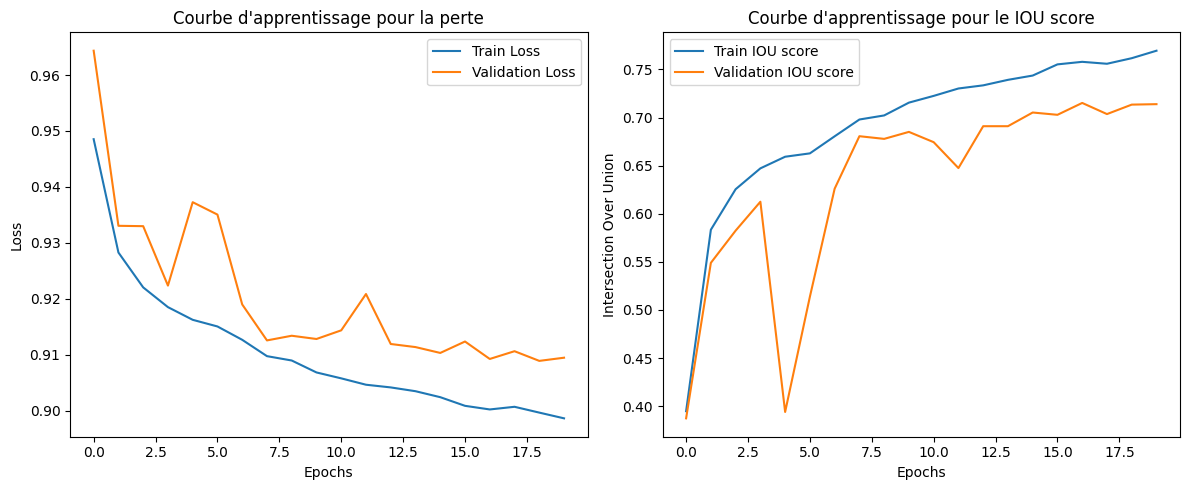

CPU times: total: 54min 1s
Wall time: 1h 19min 24s


In [8]:
%%time
model_name = "_Unet_vgg16"
num_epochs = 30
model = sm.Unet(
    "vgg16",
    input_shape=(256, 256, 3),
    classes=len(train_gen.categories),
    activation="softmax",
)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + model_name
visualize_callback = VisualizeCallback(
    generator=train_gen, model_name=model_name, log_dir=log_dir
)
checkpoint_callback = ModelCheckpoint(
    "saved_model/Unet_vgg16", save_best_only=True, monitor="val_iou_score", mode="max"
)
tensorboard_callback = TensorBoard(log_dir=log_dir, write_graph=True, write_images=True)
early_stopping = EarlyStopping(monitor="val_iou_score", patience=3, mode="max")
model.compile(optimizer="adam", loss=dice_loss, metrics=[jaccard_index, dice_coef])
history = model.fit(
    train_gen,
    epochs=num_epochs,
    validation_data=val_gen,
    callbacks=[
        checkpoint_callback,
        tensorboard_callback,
        early_stopping,
        visualize_callback,
    ],
)
scores = model.evaluate(val_gen, verbose=0)
print("Loss:", scores[0])
print("IOU score:", scores[1])
print("F1 score:", scores[2])
plot_history(history)

### Unet - Backbone : efficientnetb3

Epoch 1/30
87/87 [==============================] - ETA: 0s - loss: 0.9538 - iou_score: 0.2877 - f1-score: 0.4004INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets



Generating output at epoch : 0
1/1 [==============================] - 2s 2s/step
Wrote file to disk
87/87 [==============================] - 297s 3s/step - loss: 0.9538 - iou_score: 0.2877 - f1-score: 0.4004 - val_loss: 0.9713 - val_iou_score: 0.2711 - val_f1-score: 0.3919
Epoch 2/30
87/87 [==============================] - ETA: 0s - loss: 0.9204 - iou_score: 0.6010 - f1-score: 0.7252INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets



Generating output at epoch : 1
1/1 [==============================] - 0s 28ms/step
Wrote file to disk
87/87 [==============================] - 276s 3s/step - loss: 0.9204 - iou_score: 0.6010 - f1-score: 0.7252 - val_loss: 0.9411 - val_iou_score: 0.4770 - val_f1-score: 0.6164
Epoch 3/30
87/87 [==============================] - ETA: 0s - loss: 0.9122 - iou_score: 0.6760 - f1-score: 0.7908INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets



Generating output at epoch : 2
1/1 [==============================] - 0s 27ms/step
Wrote file to disk
87/87 [==============================] - 278s 3s/step - loss: 0.9122 - iou_score: 0.6760 - f1-score: 0.7908 - val_loss: 0.9352 - val_iou_score: 0.5347 - val_f1-score: 0.6705
Epoch 4/30
87/87 [==============================] - ETA: 0s - loss: 0.9082 - iou_score: 0.7061 - f1-score: 0.8147INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets



Generating output at epoch : 3
1/1 [==============================] - 0s 28ms/step
Wrote file to disk
87/87 [==============================] - 281s 3s/step - loss: 0.9082 - iou_score: 0.7061 - f1-score: 0.8147 - val_loss: 0.9180 - val_iou_score: 0.6476 - val_f1-score: 0.7692
Epoch 5/30
87/87 [==============================] - ETA: 0s - loss: 0.9058 - iou_score: 0.7238 - f1-score: 0.8282
Generating output at epoch : 4
1/1 [==============================] - 0s 31ms/step
Wrote file to disk
87/87 [==============================] - 243s 3s/step - loss: 0.9058 - iou_score: 0.7238 - f1-score: 0.8282 - val_loss: 0.9179 - val_iou_score: 0.6454 - val_f1-score: 0.7678
Epoch 6/30
87/87 [==============================] - ETA: 0s - loss: 0.9037 - iou_score: 0.7377 - f1-score: 0.8389INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets



Generating output at epoch : 5
1/1 [==============================] - 0s 30ms/step
Wrote file to disk
87/87 [==============================] - 286s 3s/step - loss: 0.9037 - iou_score: 0.7377 - f1-score: 0.8389 - val_loss: 0.9161 - val_iou_score: 0.6655 - val_f1-score: 0.7851
Epoch 7/30
87/87 [==============================] - ETA: 0s - loss: 0.9023 - iou_score: 0.7492 - f1-score: 0.8473INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets



Generating output at epoch : 6
1/1 [==============================] - 0s 35ms/step
Wrote file to disk
87/87 [==============================] - 292s 3s/step - loss: 0.9023 - iou_score: 0.7492 - f1-score: 0.8473 - val_loss: 0.9109 - val_iou_score: 0.7013 - val_f1-score: 0.8111
Epoch 8/30
87/87 [==============================] - ETA: 0s - loss: 0.9010 - iou_score: 0.7564 - f1-score: 0.8528INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets



Generating output at epoch : 7
1/1 [==============================] - 0s 32ms/step
Wrote file to disk
87/87 [==============================] - 292s 3s/step - loss: 0.9010 - iou_score: 0.7564 - f1-score: 0.8528 - val_loss: 0.9087 - val_iou_score: 0.7113 - val_f1-score: 0.8191
Epoch 9/30
87/87 [==============================] - ETA: 0s - loss: 0.9003 - iou_score: 0.7618 - f1-score: 0.8567INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets



Generating output at epoch : 8
1/1 [==============================] - 0s 30ms/step
Wrote file to disk
87/87 [==============================] - 291s 3s/step - loss: 0.9003 - iou_score: 0.7618 - f1-score: 0.8567 - val_loss: 0.9084 - val_iou_score: 0.7201 - val_f1-score: 0.8253
Epoch 10/30
87/87 [==============================] - ETA: 0s - loss: 0.8997 - iou_score: 0.7663 - f1-score: 0.8601INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets



Generating output at epoch : 9
1/1 [==============================] - 0s 31ms/step
Wrote file to disk
87/87 [==============================] - 290s 3s/step - loss: 0.8997 - iou_score: 0.7663 - f1-score: 0.8601 - val_loss: 0.9080 - val_iou_score: 0.7208 - val_f1-score: 0.8251
Epoch 11/30
87/87 [==============================] - ETA: 0s - loss: 0.8989 - iou_score: 0.7712 - f1-score: 0.8636INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets



Generating output at epoch : 10
1/1 [==============================] - 0s 31ms/step
Wrote file to disk
87/87 [==============================] - 295s 3s/step - loss: 0.8989 - iou_score: 0.7712 - f1-score: 0.8636 - val_loss: 0.9075 - val_iou_score: 0.7256 - val_f1-score: 0.8291
Epoch 12/30
87/87 [==============================] - ETA: 0s - loss: 0.8984 - iou_score: 0.7760 - f1-score: 0.8667INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets



Generating output at epoch : 11
1/1 [==============================] - 0s 37ms/step
Wrote file to disk
87/87 [==============================] - 294s 3s/step - loss: 0.8984 - iou_score: 0.7760 - f1-score: 0.8667 - val_loss: 0.9074 - val_iou_score: 0.7265 - val_f1-score: 0.8293
Epoch 13/30
87/87 [==============================] - ETA: 0s - loss: 0.8977 - iou_score: 0.7798 - f1-score: 0.8697INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets



Generating output at epoch : 12
1/1 [==============================] - 0s 32ms/step
Wrote file to disk
87/87 [==============================] - 295s 3s/step - loss: 0.8977 - iou_score: 0.7798 - f1-score: 0.8697 - val_loss: 0.9064 - val_iou_score: 0.7322 - val_f1-score: 0.8339
Epoch 14/30
87/87 [==============================] - ETA: 0s - loss: 0.8970 - iou_score: 0.7842 - f1-score: 0.8727
Generating output at epoch : 13
1/1 [==============================] - 0s 31ms/step
Wrote file to disk
87/87 [==============================] - 252s 3s/step - loss: 0.8970 - iou_score: 0.7842 - f1-score: 0.8727 - val_loss: 0.9074 - val_iou_score: 0.7314 - val_f1-score: 0.8323
Epoch 15/30
87/87 [==============================] - ETA: 0s - loss: 0.8965 - iou_score: 0.7875 - f1-score: 0.8752
Generating output at epoch : 14
1/1 [==============================] - 0s 32ms/step
Wrote file to disk
87/87 [==============================] - 256s 3s/step - loss: 0.8965 - iou_score: 0.7875 - f1-score: 0.8752 - va

INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets



Generating output at epoch : 15
1/1 [==============================] - 0s 30ms/step
Wrote file to disk
87/87 [==============================] - 296s 3s/step - loss: 0.8961 - iou_score: 0.7898 - f1-score: 0.8767 - val_loss: 0.9059 - val_iou_score: 0.7370 - val_f1-score: 0.8372
Epoch 17/30
87/87 [==============================] - ETA: 0s - loss: 0.8955 - iou_score: 0.7939 - f1-score: 0.8795
Generating output at epoch : 16
1/1 [==============================] - 0s 30ms/step
Wrote file to disk
87/87 [==============================] - 255s 3s/step - loss: 0.8955 - iou_score: 0.7939 - f1-score: 0.8795 - val_loss: 0.9070 - val_iou_score: 0.7243 - val_f1-score: 0.8292
Epoch 18/30
87/87 [==============================] - ETA: 0s - loss: 0.8950 - iou_score: 0.7972 - f1-score: 0.8818INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets



Generating output at epoch : 17
1/1 [==============================] - 0s 31ms/step
Wrote file to disk
87/87 [==============================] - 295s 3s/step - loss: 0.8950 - iou_score: 0.7972 - f1-score: 0.8818 - val_loss: 0.9056 - val_iou_score: 0.7378 - val_f1-score: 0.8377
Epoch 19/30
87/87 [==============================] - ETA: 0s - loss: 0.8952 - iou_score: 0.7966 - f1-score: 0.8814
Generating output at epoch : 18
1/1 [==============================] - 0s 33ms/step
Wrote file to disk
87/87 [==============================] - 252s 3s/step - loss: 0.8952 - iou_score: 0.7966 - f1-score: 0.8814 - val_loss: 0.9079 - val_iou_score: 0.7299 - val_f1-score: 0.8318
Epoch 20/30
87/87 [==============================] - ETA: 0s - loss: 0.8948 - iou_score: 0.7993 - f1-score: 0.8832INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3\assets



Generating output at epoch : 19
1/1 [==============================] - 0s 32ms/step
Wrote file to disk
87/87 [==============================] - 294s 3s/step - loss: 0.8948 - iou_score: 0.7993 - f1-score: 0.8832 - val_loss: 0.9048 - val_iou_score: 0.7435 - val_f1-score: 0.8425
Epoch 21/30
87/87 [==============================] - ETA: 0s - loss: 0.8947 - iou_score: 0.7990 - f1-score: 0.8831
Generating output at epoch : 20
1/1 [==============================] - 0s 30ms/step
Wrote file to disk
87/87 [==============================] - 252s 3s/step - loss: 0.8947 - iou_score: 0.7990 - f1-score: 0.8831 - val_loss: 0.9054 - val_iou_score: 0.7376 - val_f1-score: 0.8383
Epoch 22/30
87/87 [==============================] - ETA: 0s - loss: 0.8940 - iou_score: 0.8034 - f1-score: 0.8862
Generating output at epoch : 21
1/1 [==============================] - 0s 31ms/step
Wrote file to disk
87/87 [==============================] - 252s 3s/step - loss: 0.8940 - iou_score: 0.8034 - f1-score: 0.8862 - va

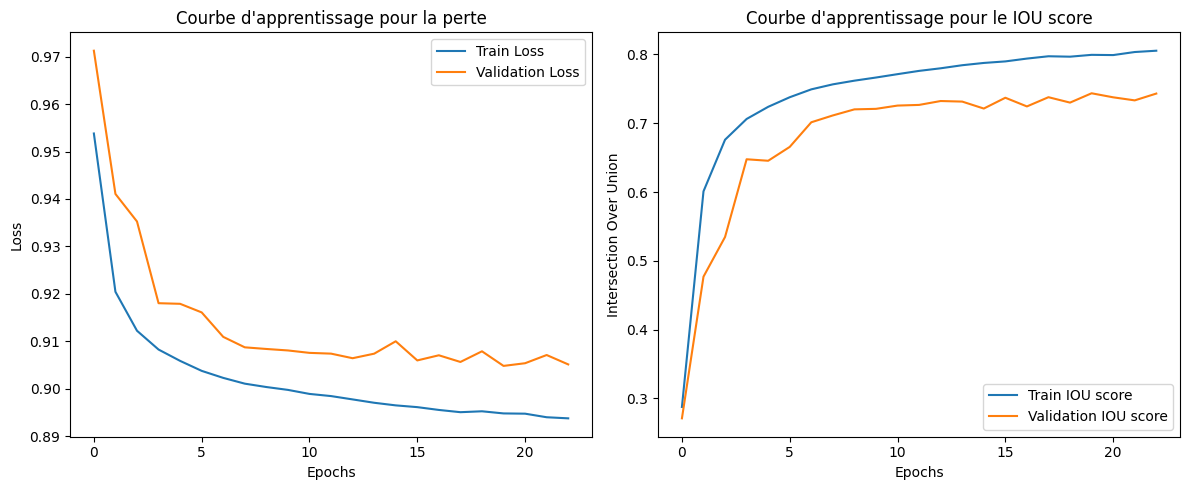

CPU times: total: 1h 8min 52s
Wall time: 1h 46min 46s


In [7]:
%%time
model_name = "_Unet_efficientnetb3"
num_epochs = 30
model = sm.Unet(
    "efficientnetb3",
    input_shape=(256, 256, 3),
    classes=len(train_gen.categories),
    activation="softmax",
)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + model_name
visualize_callback = VisualizeCallback(
    generator=train_gen, model_name=model_name, log_dir=log_dir
)
checkpoint_callback = ModelCheckpoint(
    "saved_model/Unet_efficientnetb3",
    save_best_only=True,
    monitor="val_iou_score",
    mode="max",
)
tensorboard_callback = TensorBoard(log_dir=log_dir, write_graph=True, write_images=True)
early_stopping = EarlyStopping(monitor="val_iou_score", patience=3, mode="max")
model.compile(optimizer="adam", loss=dice_loss, metrics=[jaccard_index, dice_coef])
history = model.fit(
    train_gen,
    epochs=num_epochs,
    validation_data=val_gen,
    callbacks=[
        checkpoint_callback,
        tensorboard_callback,
        early_stopping,
        visualize_callback,
    ],
)
scores = model.evaluate(val_gen, verbose=0)
print("Loss:", scores[0])
print("IOU score:", scores[1])
print("F1 score:", scores[2])
plot_history(history)

Le modèle U-net avec une extraction de feature effectuée avec le backbone `efficientnet3` montre de meilleures performances.  
**1ère époque** :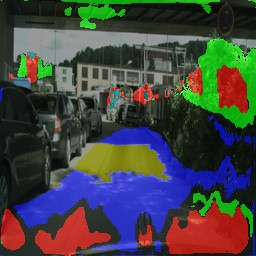
**20ème époque** : 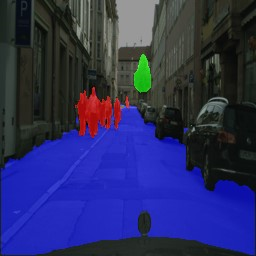

### Comparatif data augmentation

Epoch 1/50
87/87 [==============================] - ETA: 0s - loss: 0.9555 - iou_score: 0.2812 - f1-score: 0.3933INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets



Generating output at epoch : 0
1/1 [==============================] - 2s 2s/step
Wrote file to disk
87/87 [==============================] - 317s 3s/step - loss: 0.9555 - iou_score: 0.2812 - f1-score: 0.3933 - val_loss: 0.9697 - val_iou_score: 0.2215 - val_f1-score: 0.3478
Epoch 2/50
87/87 [==============================] - ETA: 0s - loss: 0.9228 - iou_score: 0.5900 - f1-score: 0.7164INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets



Generating output at epoch : 1
1/1 [==============================] - 0s 25ms/step
Wrote file to disk
87/87 [==============================] - 276s 3s/step - loss: 0.9228 - iou_score: 0.5900 - f1-score: 0.7164 - val_loss: 0.9377 - val_iou_score: 0.4495 - val_f1-score: 0.5953
Epoch 3/50
87/87 [==============================] - ETA: 0s - loss: 0.9141 - iou_score: 0.6668 - f1-score: 0.7835INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets



Generating output at epoch : 2
1/1 [==============================] - 0s 26ms/step
Wrote file to disk
87/87 [==============================] - 275s 3s/step - loss: 0.9141 - iou_score: 0.6668 - f1-score: 0.7835 - val_loss: 0.9231 - val_iou_score: 0.6024 - val_f1-score: 0.7330
Epoch 4/50
87/87 [==============================] - ETA: 0s - loss: 0.9111 - iou_score: 0.6890 - f1-score: 0.8014INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets



Generating output at epoch : 3
1/1 [==============================] - 0s 25ms/step
Wrote file to disk
87/87 [==============================] - 281s 3s/step - loss: 0.9111 - iou_score: 0.6890 - f1-score: 0.8014 - val_loss: 0.9268 - val_iou_score: 0.6094 - val_f1-score: 0.7361
Epoch 5/50
87/87 [==============================] - ETA: 0s - loss: 0.9090 - iou_score: 0.7079 - f1-score: 0.8160INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets



Generating output at epoch : 4
1/1 [==============================] - 0s 27ms/step
Wrote file to disk
87/87 [==============================] - 280s 3s/step - loss: 0.9090 - iou_score: 0.7079 - f1-score: 0.8160 - val_loss: 0.9128 - val_iou_score: 0.6781 - val_f1-score: 0.7943
Epoch 6/50
87/87 [==============================] - ETA: 0s - loss: 0.9071 - iou_score: 0.7224 - f1-score: 0.8267INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets



Generating output at epoch : 5
1/1 [==============================] - 0s 26ms/step
Wrote file to disk
87/87 [==============================] - 285s 3s/step - loss: 0.9071 - iou_score: 0.7224 - f1-score: 0.8267 - val_loss: 0.9117 - val_iou_score: 0.6929 - val_f1-score: 0.8046
Epoch 7/50
87/87 [==============================] - ETA: 0s - loss: 0.9064 - iou_score: 0.7281 - f1-score: 0.8312INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets



Generating output at epoch : 6
1/1 [==============================] - 0s 26ms/step
Wrote file to disk
87/87 [==============================] - 287s 3s/step - loss: 0.9064 - iou_score: 0.7281 - f1-score: 0.8312 - val_loss: 0.9109 - val_iou_score: 0.7047 - val_f1-score: 0.8128
Epoch 8/50
87/87 [==============================] - ETA: 0s - loss: 0.9052 - iou_score: 0.7344 - f1-score: 0.8360INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets



Generating output at epoch : 7
1/1 [==============================] - 0s 28ms/step
Wrote file to disk
87/87 [==============================] - 286s 3s/step - loss: 0.9052 - iou_score: 0.7344 - f1-score: 0.8360 - val_loss: 0.9092 - val_iou_score: 0.7134 - val_f1-score: 0.8193
Epoch 9/50
87/87 [==============================] - ETA: 0s - loss: 0.9045 - iou_score: 0.7410 - f1-score: 0.8408
Generating output at epoch : 8
1/1 [==============================] - 0s 26ms/step
Wrote file to disk
87/87 [==============================] - 250s 3s/step - loss: 0.9045 - iou_score: 0.7410 - f1-score: 0.8408 - val_loss: 0.9086 - val_iou_score: 0.7111 - val_f1-score: 0.8190
Epoch 10/50
87/87 [==============================] - ETA: 0s - loss: 0.9036 - iou_score: 0.7459 - f1-score: 0.8445INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets



Generating output at epoch : 9
1/1 [==============================] - 0s 27ms/step
Wrote file to disk
87/87 [==============================] - 290s 3s/step - loss: 0.9036 - iou_score: 0.7459 - f1-score: 0.8445 - val_loss: 0.9072 - val_iou_score: 0.7196 - val_f1-score: 0.8254
Epoch 11/50
87/87 [==============================] - ETA: 0s - loss: 0.9034 - iou_score: 0.7470 - f1-score: 0.8455
Generating output at epoch : 10
1/1 [==============================] - 0s 27ms/step
Wrote file to disk
87/87 [==============================] - 250s 3s/step - loss: 0.9034 - iou_score: 0.7470 - f1-score: 0.8455 - val_loss: 0.9076 - val_iou_score: 0.7172 - val_f1-score: 0.8242
Epoch 12/50
87/87 [==============================] - ETA: 0s - loss: 0.9030 - iou_score: 0.7499 - f1-score: 0.8475
Generating output at epoch : 11
1/1 [==============================] - 0s 27ms/step
Wrote file to disk
87/87 [==============================] - 249s 3s/step - loss: 0.9030 - iou_score: 0.7499 - f1-score: 0.8475 - val

INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets



Generating output at epoch : 12
1/1 [==============================] - 0s 27ms/step
Wrote file to disk
87/87 [==============================] - 290s 3s/step - loss: 0.9022 - iou_score: 0.7543 - f1-score: 0.8509 - val_loss: 0.9076 - val_iou_score: 0.7249 - val_f1-score: 0.8285
Epoch 14/50
87/87 [==============================] - ETA: 0s - loss: 0.9019 - iou_score: 0.7572 - f1-score: 0.8529INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets



Generating output at epoch : 13
1/1 [==============================] - 0s 28ms/step
Wrote file to disk
87/87 [==============================] - 292s 3s/step - loss: 0.9019 - iou_score: 0.7572 - f1-score: 0.8529 - val_loss: 0.9076 - val_iou_score: 0.7269 - val_f1-score: 0.8295
Epoch 15/50
87/87 [==============================] - ETA: 0s - loss: 0.9018 - iou_score: 0.7577 - f1-score: 0.8532
Generating output at epoch : 14
1/1 [==============================] - 0s 27ms/step
Wrote file to disk
87/87 [==============================] - 253s 3s/step - loss: 0.9018 - iou_score: 0.7577 - f1-score: 0.8532 - val_loss: 0.9076 - val_iou_score: 0.7245 - val_f1-score: 0.8286
Epoch 16/50
87/87 [==============================] - ETA: 0s - loss: 0.9010 - iou_score: 0.7630 - f1-score: 0.8570INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets



Generating output at epoch : 15
1/1 [==============================] - 0s 26ms/step
Wrote file to disk
87/87 [==============================] - 310s 4s/step - loss: 0.9010 - iou_score: 0.7630 - f1-score: 0.8570 - val_loss: 0.9062 - val_iou_score: 0.7315 - val_f1-score: 0.8340
Epoch 17/50
87/87 [==============================] - ETA: 0s - loss: 0.9007 - iou_score: 0.7644 - f1-score: 0.8582
Generating output at epoch : 16
1/1 [==============================] - 0s 27ms/step
Wrote file to disk
87/87 [==============================] - 249s 3s/step - loss: 0.9007 - iou_score: 0.7644 - f1-score: 0.8582 - val_loss: 0.9071 - val_iou_score: 0.7293 - val_f1-score: 0.8315
Epoch 18/50
87/87 [==============================] - ETA: 0s - loss: 0.9001 - iou_score: 0.7687 - f1-score: 0.8613INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets



Generating output at epoch : 17
1/1 [==============================] - 0s 28ms/step
Wrote file to disk
87/87 [==============================] - 293s 3s/step - loss: 0.9001 - iou_score: 0.7687 - f1-score: 0.8613 - val_loss: 0.9053 - val_iou_score: 0.7384 - val_f1-score: 0.8391
Epoch 19/50
87/87 [==============================] - ETA: 0s - loss: 0.8996 - iou_score: 0.7708 - f1-score: 0.8628
Generating output at epoch : 18
1/1 [==============================] - 0s 26ms/step
Wrote file to disk
87/87 [==============================] - 270s 3s/step - loss: 0.8996 - iou_score: 0.7708 - f1-score: 0.8628 - val_loss: 0.9067 - val_iou_score: 0.7315 - val_f1-score: 0.8336
Epoch 20/50
87/87 [==============================] - ETA: 0s - loss: 0.8993 - iou_score: 0.7729 - f1-score: 0.8643INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets



Generating output at epoch : 19
1/1 [==============================] - 0s 27ms/step
Wrote file to disk
87/87 [==============================] - 292s 3s/step - loss: 0.8993 - iou_score: 0.7729 - f1-score: 0.8643 - val_loss: 0.9049 - val_iou_score: 0.7385 - val_f1-score: 0.8393
Epoch 21/50
87/87 [==============================] - ETA: 0s - loss: 0.8995 - iou_score: 0.7726 - f1-score: 0.8640
Generating output at epoch : 20
1/1 [==============================] - 0s 26ms/step
Wrote file to disk
87/87 [==============================] - 257s 3s/step - loss: 0.8995 - iou_score: 0.7726 - f1-score: 0.8640 - val_loss: 0.9064 - val_iou_score: 0.7310 - val_f1-score: 0.8336
Epoch 22/50
87/87 [==============================] - ETA: 0s - loss: 0.8991 - iou_score: 0.7740 - f1-score: 0.8652INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets


INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets



Generating output at epoch : 21
1/1 [==============================] - 0s 27ms/step
Wrote file to disk
87/87 [==============================] - 293s 3s/step - loss: 0.8991 - iou_score: 0.7740 - f1-score: 0.8652 - val_loss: 0.9047 - val_iou_score: 0.7407 - val_f1-score: 0.8407
Epoch 23/50
87/87 [==============================] - ETA: 0s - loss: 0.8987 - iou_score: 0.7769 - f1-score: 0.8672
Generating output at epoch : 22
1/1 [==============================] - 0s 28ms/step
Wrote file to disk
87/87 [==============================] - 272s 3s/step - loss: 0.8987 - iou_score: 0.7769 - f1-score: 0.8672 - val_loss: 0.9056 - val_iou_score: 0.7340 - val_f1-score: 0.8362
Epoch 24/50
87/87 [==============================] - ETA: 0s - loss: 0.8986 - iou_score: 0.7776 - f1-score: 0.8677
Generating output at epoch : 23
1/1 [==============================] - 0s 27ms/step
Wrote file to disk
87/87 [==============================] - 269s 3s/step - loss: 0.8986 - iou_score: 0.7776 - f1-score: 0.8677 - va

INFO:tensorflow:Assets written to: saved_model\Unet_efficientnetb3_aug\assets



Generating output at epoch : 24
1/1 [==============================] - 0s 28ms/step
Wrote file to disk
87/87 [==============================] - 296s 3s/step - loss: 0.8983 - iou_score: 0.7799 - f1-score: 0.8692 - val_loss: 0.9043 - val_iou_score: 0.7417 - val_f1-score: 0.8420
Epoch 26/50
87/87 [==============================] - ETA: 0s - loss: 0.8978 - iou_score: 0.7822 - f1-score: 0.8709
Generating output at epoch : 25
1/1 [==============================] - 0s 27ms/step
Wrote file to disk
87/87 [==============================] - 258s 3s/step - loss: 0.8978 - iou_score: 0.7822 - f1-score: 0.8709 - val_loss: 0.9046 - val_iou_score: 0.7414 - val_f1-score: 0.8415
Epoch 27/50
87/87 [==============================] - ETA: 0s - loss: 0.8979 - iou_score: 0.7824 - f1-score: 0.8711
Generating output at epoch : 26
1/1 [==============================] - 0s 29ms/step
Wrote file to disk
87/87 [==============================] - 258s 3s/step - loss: 0.8979 - iou_score: 0.7824 - f1-score: 0.8711 - va

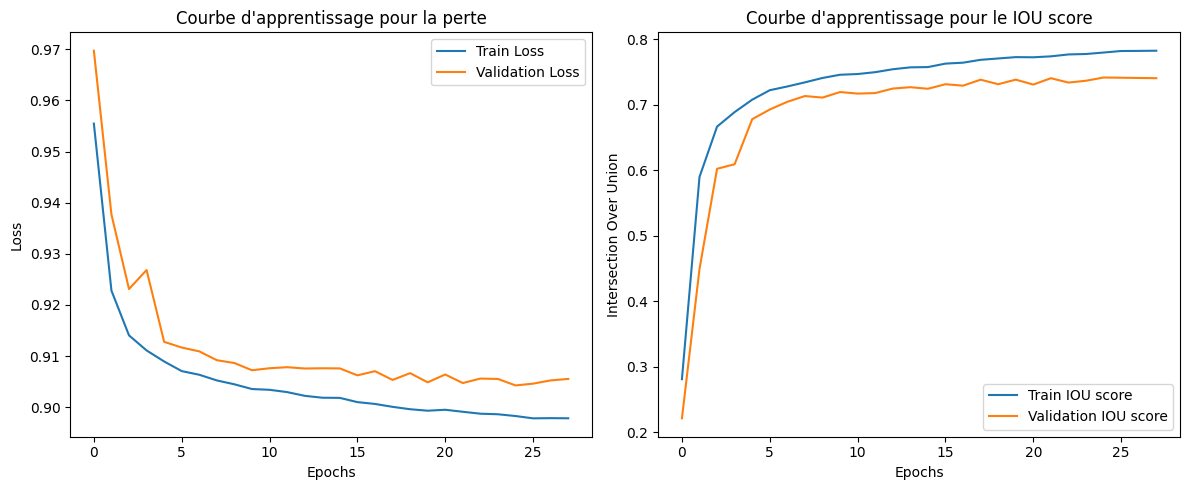

CPU times: total: 1h 22min 2s
Wall time: 2h 10min 32s


In [7]:
%%time
epochs = 50
model_name = "_Unet_efficientnetb3_aug"
model = sm.Unet(
    "efficientnetb3",
    input_shape=(256, 256, 3),
    classes=len(train_gen.categories),
    activation="softmax",
)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + model_name
visualize_callback = VisualizeCallback(
    generator=train_gen_aug, model_name=model_name, log_dir=log_dir
)
checkpoint_callback = ModelCheckpoint(
    "saved_model/Unet_efficientnetb3_aug",
    save_best_only=True,
    monitor="val_iou_score",
    mode="max",
)
tensorboard_callback = TensorBoard(log_dir=log_dir, write_graph=True, write_images=True)
early_stopping = EarlyStopping(monitor="val_iou_score", patience=3, mode="max")
model.compile(optimizer="adam", loss=dice_loss, metrics=[jaccard_index, dice_coef])
history = model.fit(
    train_gen_aug,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=[
        checkpoint_callback,
        tensorboard_callback,
        early_stopping,
        visualize_callback,
    ],
)
scores = model.evaluate(val_gen, verbose=0)
print("Loss:", scores[0])
print("IOU score:", scores[1])
print("F1 score:", scores[2])
plot_history(history)

On note une légère amélioration des performances et un courbe d'apprentissage plus stable en utilisant la data augmentation.  
26ème époque : 
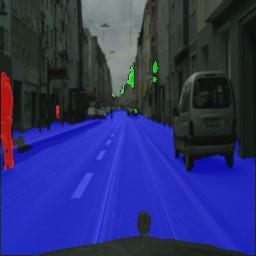

2/2 [==============================] - 2s 202ms/step


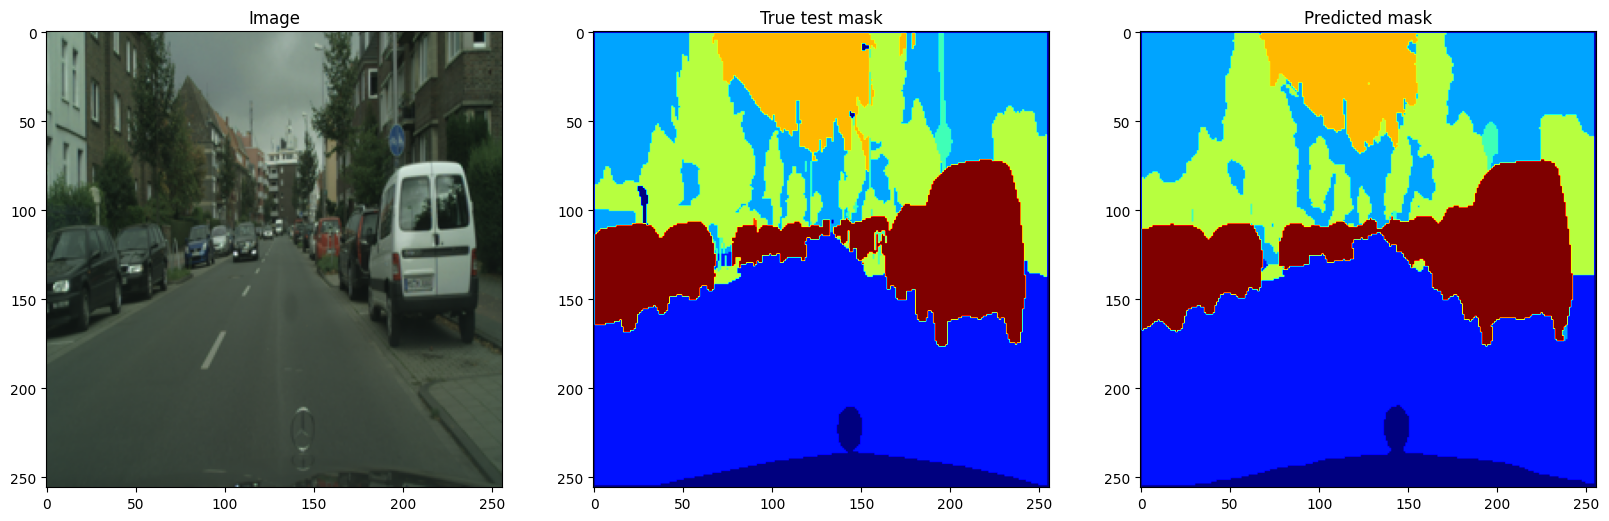

In [9]:
images, true_masks = val_gen[0]
true_mask = np.argmax(true_masks[0], axis=-1)

predicted_masks = model.predict(images)
predicted_class = np.argmax(predicted_masks[0], axis=-1)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(images[0])
ax[0].set_title("Image")
ax[1].imshow(true_mask, cmap="jet")
ax[1].set_title("True test mask")
ax[2].imshow(predicted_class, cmap="jet")
ax[2].set_title("Predicted mask")
plt.show()

### FPN

Epoch 1/30
185/185 [==============================] - ETA: 0s - loss: 0.9254 - iou_score: 0.6125 - f1-score: 0.7326INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3\assets


INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3\assets



Generating output at epoch : 0
1/1 [==============================] - 2s 2s/step
Wrote file to disk
185/185 [==============================] - 300s 2s/step - loss: 0.9254 - iou_score: 0.6125 - f1-score: 0.7326 - val_loss: 0.9331 - val_iou_score: 0.5872 - val_f1-score: 0.7120
Epoch 2/30
185/185 [==============================] - ETA: 0s - loss: 0.9122 - iou_score: 0.7001 - f1-score: 0.8081INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3\assets


INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3\assets



Generating output at epoch : 1
1/1 [==============================] - 0s 25ms/step
Wrote file to disk
185/185 [==============================] - 271s 1s/step - loss: 0.9122 - iou_score: 0.7001 - f1-score: 0.8081 - val_loss: 0.9226 - val_iou_score: 0.6501 - val_f1-score: 0.7670
Epoch 3/30
185/185 [==============================] - ETA: 0s - loss: 0.9077 - iou_score: 0.7252 - f1-score: 0.8281INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3\assets


INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3\assets



Generating output at epoch : 2
1/1 [==============================] - 0s 27ms/step
Wrote file to disk
185/185 [==============================] - 273s 1s/step - loss: 0.9077 - iou_score: 0.7252 - f1-score: 0.8281 - val_loss: 0.9159 - val_iou_score: 0.6841 - val_f1-score: 0.7946
Epoch 4/30
185/185 [==============================] - ETA: 0s - loss: 0.9053 - iou_score: 0.7395 - f1-score: 0.8390INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3\assets


INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3\assets



Generating output at epoch : 3
1/1 [==============================] - 0s 27ms/step
Wrote file to disk
185/185 [==============================] - 276s 1s/step - loss: 0.9053 - iou_score: 0.7395 - f1-score: 0.8390 - val_loss: 0.9100 - val_iou_score: 0.7074 - val_f1-score: 0.8160
Epoch 5/30
185/185 [==============================] - ETA: 0s - loss: 0.9033 - iou_score: 0.7517 - f1-score: 0.8481INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3\assets


INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3\assets



Generating output at epoch : 4
1/1 [==============================] - 0s 27ms/step
Wrote file to disk
185/185 [==============================] - 278s 2s/step - loss: 0.9033 - iou_score: 0.7517 - f1-score: 0.8481 - val_loss: 0.9090 - val_iou_score: 0.7191 - val_f1-score: 0.8237
Epoch 6/30
185/185 [==============================] - ETA: 0s - loss: 0.9021 - iou_score: 0.7583 - f1-score: 0.8532INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3\assets


INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3\assets



Generating output at epoch : 5
1/1 [==============================] - 0s 28ms/step
Wrote file to disk
185/185 [==============================] - 280s 2s/step - loss: 0.9021 - iou_score: 0.7583 - f1-score: 0.8532 - val_loss: 0.9095 - val_iou_score: 0.7242 - val_f1-score: 0.8261
Epoch 7/30
185/185 [==============================] - ETA: 0s - loss: 0.9009 - iou_score: 0.7654 - f1-score: 0.8585
Generating output at epoch : 6
1/1 [==============================] - 0s 27ms/step
Wrote file to disk
185/185 [==============================] - 242s 1s/step - loss: 0.9009 - iou_score: 0.7654 - f1-score: 0.8585 - val_loss: 0.9086 - val_iou_score: 0.7233 - val_f1-score: 0.8264
Epoch 8/30
185/185 [==============================] - ETA: 0s - loss: 0.8999 - iou_score: 0.7720 - f1-score: 0.8631INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3\assets


INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3\assets



Generating output at epoch : 7
1/1 [==============================] - 0s 27ms/step
Wrote file to disk
185/185 [==============================] - 284s 2s/step - loss: 0.8999 - iou_score: 0.7720 - f1-score: 0.8631 - val_loss: 0.9071 - val_iou_score: 0.7307 - val_f1-score: 0.8326
Epoch 9/30
185/185 [==============================] - ETA: 0s - loss: 0.8990 - iou_score: 0.7773 - f1-score: 0.8670
Generating output at epoch : 8
1/1 [==============================] - 0s 27ms/step
Wrote file to disk
185/185 [==============================] - 240s 1s/step - loss: 0.8990 - iou_score: 0.7773 - f1-score: 0.8670 - val_loss: 0.9124 - val_iou_score: 0.7167 - val_f1-score: 0.8191
Epoch 10/30
185/185 [==============================] - ETA: 0s - loss: 0.8985 - iou_score: 0.7792 - f1-score: 0.8686INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3\assets


INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3\assets



Generating output at epoch : 9
1/1 [==============================] - 0s 35ms/step
Wrote file to disk
185/185 [==============================] - 280s 2s/step - loss: 0.8985 - iou_score: 0.7792 - f1-score: 0.8686 - val_loss: 0.9072 - val_iou_score: 0.7315 - val_f1-score: 0.8332
Epoch 11/30
185/185 [==============================] - ETA: 0s - loss: 0.8977 - iou_score: 0.7853 - f1-score: 0.8728INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3\assets


INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3\assets



Generating output at epoch : 10
1/1 [==============================] - 0s 34ms/step
Wrote file to disk
185/185 [==============================] - 283s 2s/step - loss: 0.8977 - iou_score: 0.7853 - f1-score: 0.8728 - val_loss: 0.9064 - val_iou_score: 0.7388 - val_f1-score: 0.8379
Epoch 12/30
185/185 [==============================] - ETA: 0s - loss: 0.8965 - iou_score: 0.7917 - f1-score: 0.8774
Generating output at epoch : 11
1/1 [==============================] - 0s 28ms/step
Wrote file to disk
185/185 [==============================] - 248s 1s/step - loss: 0.8965 - iou_score: 0.7917 - f1-score: 0.8774 - val_loss: 0.9078 - val_iou_score: 0.7306 - val_f1-score: 0.8318
Epoch 13/30
185/185 [==============================] - ETA: 0s - loss: 0.8963 - iou_score: 0.7933 - f1-score: 0.8786
Generating output at epoch : 12
1/1 [==============================] - 0s 28ms/step
Wrote file to disk
185/185 [==============================] - 248s 1s/step - loss: 0.8963 - iou_score: 0.7933 - f1-score: 0

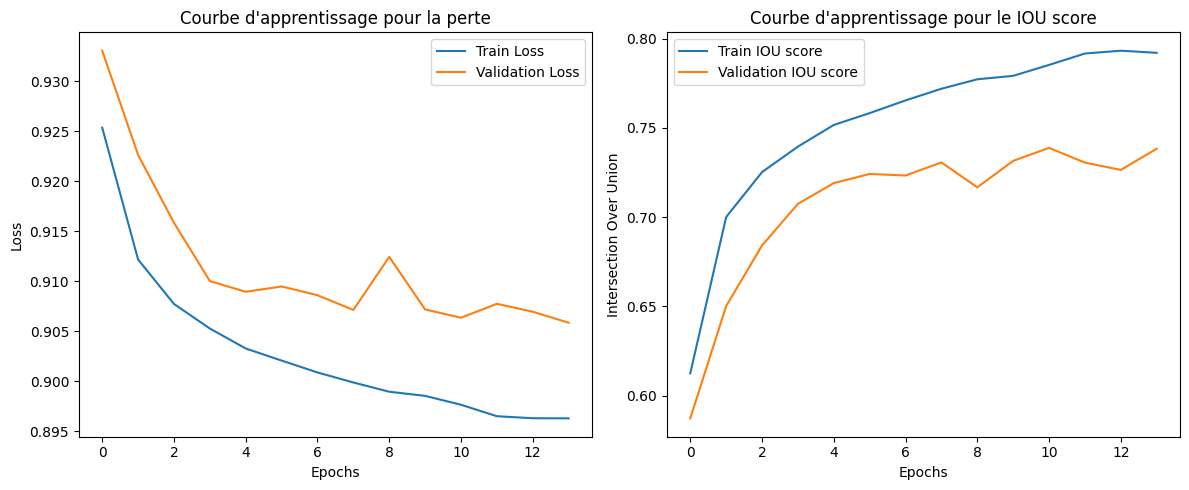

In [7]:
num_epochs = 30
model_name = "_FPN_efficientnetb3"
model = sm.FPN(
    "efficientnetb3",
    input_shape=(256, 256, 3),
    classes=len(train_gen.categories),
    activation="softmax",
)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + model_name
visualize_callback = VisualizeCallback(
    generator=train_gen_aug, model_name=model_name, log_dir=log_dir
)
checkpoint_callback = ModelCheckpoint(
    "saved_model/FPN_efficientnetb3",
    save_best_only=True,
    monitor="val_iou_score",
    mode="max",
)
tensorboard_callback = TensorBoard(log_dir=log_dir, write_graph=True, write_images=True)
early_stopping = EarlyStopping(monitor="val_iou_score", patience=3, mode="max")
model.compile(optimizer="adam", loss=dice_loss, metrics=[jaccard_index, dice_coef])
history = model.fit(
    train_gen,
    epochs=num_epochs,
    validation_data=val_gen,
    callbacks=[
        checkpoint_callback,
        tensorboard_callback,
        early_stopping,
        visualize_callback,
    ],
)
scores = model.evaluate(val_gen, verbose=0)
print("Loss:", scores[0])
print("IOU score:", scores[1])
print("F1 score:", scores[2])
plot_history(history)

Epoch 1/30
185/185 [==============================] - ETA: 0s - loss: 0.9286 - iou_score: 0.5941 - f1-score: 0.7170INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3_aug\assets


INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3_aug\assets



Generating output at epoch : 0
1/1 [==============================] - 2s 2s/step
Wrote file to disk
185/185 [==============================] - 293s 1s/step - loss: 0.9286 - iou_score: 0.5941 - f1-score: 0.7170 - val_loss: 0.9305 - val_iou_score: 0.5620 - val_f1-score: 0.6972
Epoch 2/30
185/185 [==============================] - ETA: 0s - loss: 0.9169 - iou_score: 0.6701 - f1-score: 0.7845INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3_aug\assets


INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3_aug\assets



Generating output at epoch : 1
1/1 [==============================] - 0s 26ms/step
Wrote file to disk
185/185 [==============================] - 269s 1s/step - loss: 0.9169 - iou_score: 0.6701 - f1-score: 0.7845 - val_loss: 0.9201 - val_iou_score: 0.6486 - val_f1-score: 0.7681
Epoch 3/30
185/185 [==============================] - ETA: 0s - loss: 0.9136 - iou_score: 0.6924 - f1-score: 0.8023INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3_aug\assets


INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3_aug\assets



Generating output at epoch : 2
1/1 [==============================] - 0s 26ms/step
Wrote file to disk
185/185 [==============================] - 273s 1s/step - loss: 0.9136 - iou_score: 0.6924 - f1-score: 0.8023 - val_loss: 0.9136 - val_iou_score: 0.6882 - val_f1-score: 0.7996
Epoch 4/30
185/185 [==============================] - ETA: 0s - loss: 0.9098 - iou_score: 0.7123 - f1-score: 0.8182INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3_aug\assets


INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3_aug\assets



Generating output at epoch : 3
1/1 [==============================] - 0s 26ms/step
Wrote file to disk
185/185 [==============================] - 277s 1s/step - loss: 0.9098 - iou_score: 0.7123 - f1-score: 0.8182 - val_loss: 0.9125 - val_iou_score: 0.6969 - val_f1-score: 0.8066
Epoch 5/30
185/185 [==============================] - ETA: 0s - loss: 0.9081 - iou_score: 0.7225 - f1-score: 0.8261
Generating output at epoch : 4
1/1 [==============================] - 0s 26ms/step
Wrote file to disk
185/185 [==============================] - 242s 1s/step - loss: 0.9081 - iou_score: 0.7225 - f1-score: 0.8261 - val_loss: 0.9106 - val_iou_score: 0.6949 - val_f1-score: 0.8074
Epoch 6/30
185/185 [==============================] - ETA: 0s - loss: 0.9073 - iou_score: 0.7301 - f1-score: 0.8316INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3_aug\assets


INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3_aug\assets



Generating output at epoch : 5
1/1 [==============================] - 0s 27ms/step
Wrote file to disk
185/185 [==============================] - 282s 2s/step - loss: 0.9073 - iou_score: 0.7301 - f1-score: 0.8316 - val_loss: 0.9104 - val_iou_score: 0.7115 - val_f1-score: 0.8181
Epoch 7/30
185/185 [==============================] - ETA: 0s - loss: 0.9057 - iou_score: 0.7370 - f1-score: 0.8372
Generating output at epoch : 6
1/1 [==============================] - 0s 27ms/step
Wrote file to disk
185/185 [==============================] - 246s 1s/step - loss: 0.9057 - iou_score: 0.7370 - f1-score: 0.8372 - val_loss: 0.9088 - val_iou_score: 0.7104 - val_f1-score: 0.8184
Epoch 8/30
185/185 [==============================] - ETA: 0s - loss: 0.9050 - iou_score: 0.7436 - f1-score: 0.8418INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3_aug\assets


INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3_aug\assets



Generating output at epoch : 7
1/1 [==============================] - 0s 29ms/step
Wrote file to disk
185/185 [==============================] - 285s 2s/step - loss: 0.9050 - iou_score: 0.7436 - f1-score: 0.8418 - val_loss: 0.9080 - val_iou_score: 0.7253 - val_f1-score: 0.8285
Epoch 9/30
185/185 [==============================] - ETA: 0s - loss: 0.9044 - iou_score: 0.7468 - f1-score: 0.8444
Generating output at epoch : 8
1/1 [==============================] - 0s 26ms/step
Wrote file to disk
185/185 [==============================] - 247s 1s/step - loss: 0.9044 - iou_score: 0.7468 - f1-score: 0.8444 - val_loss: 0.9074 - val_iou_score: 0.7199 - val_f1-score: 0.8253
Epoch 10/30
185/185 [==============================] - ETA: 0s - loss: 0.9037 - iou_score: 0.7510 - f1-score: 0.8476INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3_aug\assets


INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3_aug\assets



Generating output at epoch : 9
1/1 [==============================] - 0s 28ms/step
Wrote file to disk
185/185 [==============================] - 287s 2s/step - loss: 0.9037 - iou_score: 0.7510 - f1-score: 0.8476 - val_loss: 0.9074 - val_iou_score: 0.7280 - val_f1-score: 0.8306
Epoch 11/30
185/185 [==============================] - ETA: 0s - loss: 0.9034 - iou_score: 0.7523 - f1-score: 0.8485
Generating output at epoch : 10
1/1 [==============================] - 0s 28ms/step
Wrote file to disk
185/185 [==============================] - 250s 1s/step - loss: 0.9034 - iou_score: 0.7523 - f1-score: 0.8485 - val_loss: 0.9080 - val_iou_score: 0.7254 - val_f1-score: 0.8284
Epoch 12/30
185/185 [==============================] - ETA: 0s - loss: 0.9027 - iou_score: 0.7569 - f1-score: 0.8519INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3_aug\assets


INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3_aug\assets



Generating output at epoch : 11
1/1 [==============================] - 0s 28ms/step
Wrote file to disk
185/185 [==============================] - 289s 2s/step - loss: 0.9027 - iou_score: 0.7569 - f1-score: 0.8519 - val_loss: 0.9070 - val_iou_score: 0.7324 - val_f1-score: 0.8336
Epoch 13/30
185/185 [==============================] - ETA: 0s - loss: 0.9019 - iou_score: 0.7615 - f1-score: 0.8555INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3_aug\assets


INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3_aug\assets



Generating output at epoch : 12
1/1 [==============================] - 0s 28ms/step
Wrote file to disk
185/185 [==============================] - 289s 2s/step - loss: 0.9019 - iou_score: 0.7615 - f1-score: 0.8555 - val_loss: 0.9062 - val_iou_score: 0.7363 - val_f1-score: 0.8366
Epoch 14/30
185/185 [==============================] - ETA: 0s - loss: 0.9013 - iou_score: 0.7649 - f1-score: 0.8580
Generating output at epoch : 13
1/1 [==============================] - 0s 27ms/step
Wrote file to disk
185/185 [==============================] - 252s 1s/step - loss: 0.9013 - iou_score: 0.7649 - f1-score: 0.8580 - val_loss: 0.9061 - val_iou_score: 0.7348 - val_f1-score: 0.8356
Epoch 15/30
185/185 [==============================] - ETA: 0s - loss: 0.9011 - iou_score: 0.7652 - f1-score: 0.8583
Generating output at epoch : 14
1/1 [==============================] - 0s 28ms/step
Wrote file to disk
185/185 [==============================] - 255s 1s/step - loss: 0.9011 - iou_score: 0.7652 - f1-score: 0

INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3_aug\assets



Generating output at epoch : 15
1/1 [==============================] - 0s 28ms/step
Wrote file to disk
185/185 [==============================] - 296s 2s/step - loss: 0.9006 - iou_score: 0.7703 - f1-score: 0.8617 - val_loss: 0.9059 - val_iou_score: 0.7388 - val_f1-score: 0.8384
Epoch 17/30
185/185 [==============================] - ETA: 0s - loss: 0.8999 - iou_score: 0.7727 - f1-score: 0.8636INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3_aug\assets


INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3_aug\assets



Generating output at epoch : 16
1/1 [==============================] - 0s 29ms/step
Wrote file to disk
185/185 [==============================] - 295s 2s/step - loss: 0.8999 - iou_score: 0.7727 - f1-score: 0.8636 - val_loss: 0.9053 - val_iou_score: 0.7431 - val_f1-score: 0.8418
Epoch 18/30
185/185 [==============================] - ETA: 0s - loss: 0.8998 - iou_score: 0.7747 - f1-score: 0.8650
Generating output at epoch : 17
1/1 [==============================] - 0s 28ms/step
Wrote file to disk
185/185 [==============================] - 257s 1s/step - loss: 0.8998 - iou_score: 0.7747 - f1-score: 0.8650 - val_loss: 0.9063 - val_iou_score: 0.7378 - val_f1-score: 0.8375
Epoch 19/30
185/185 [==============================] - ETA: 0s - loss: 0.9001 - iou_score: 0.7717 - f1-score: 0.8631
Generating output at epoch : 18
1/1 [==============================] - 0s 29ms/step
Wrote file to disk
185/185 [==============================] - 257s 1s/step - loss: 0.9001 - iou_score: 0.7717 - f1-score: 0

INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3_aug\assets



Generating output at epoch : 19
1/1 [==============================] - 0s 28ms/step
Wrote file to disk
185/185 [==============================] - 296s 2s/step - loss: 0.8991 - iou_score: 0.7777 - f1-score: 0.8674 - val_loss: 0.9044 - val_iou_score: 0.7458 - val_f1-score: 0.8440
Epoch 21/30
185/185 [==============================] - ETA: 0s - loss: 0.8990 - iou_score: 0.7793 - f1-score: 0.8684
Generating output at epoch : 20
1/1 [==============================] - 0s 29ms/step
Wrote file to disk
185/185 [==============================] - 253s 1s/step - loss: 0.8990 - iou_score: 0.7793 - f1-score: 0.8684 - val_loss: 0.9063 - val_iou_score: 0.7412 - val_f1-score: 0.8400
Epoch 22/30
185/185 [==============================] - ETA: 0s - loss: 0.8981 - iou_score: 0.7841 - f1-score: 0.8719INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3_aug\assets


INFO:tensorflow:Assets written to: saved_model\FPN_efficientnetb3_aug\assets



Generating output at epoch : 21
1/1 [==============================] - 0s 28ms/step
Wrote file to disk
185/185 [==============================] - 293s 2s/step - loss: 0.8981 - iou_score: 0.7841 - f1-score: 0.8719 - val_loss: 0.9050 - val_iou_score: 0.7471 - val_f1-score: 0.8442
Epoch 23/30
185/185 [==============================] - ETA: 0s - loss: 0.8983 - iou_score: 0.7822 - f1-score: 0.8706
Generating output at epoch : 22
1/1 [==============================] - 0s 28ms/step
Wrote file to disk
185/185 [==============================] - 257s 1s/step - loss: 0.8983 - iou_score: 0.7822 - f1-score: 0.8706 - val_loss: 0.9048 - val_iou_score: 0.7443 - val_f1-score: 0.8426
Epoch 24/30
185/185 [==============================] - ETA: 0s - loss: 0.8981 - iou_score: 0.7841 - f1-score: 0.8719
Generating output at epoch : 23
1/1 [==============================] - 0s 29ms/step
Wrote file to disk
185/185 [==============================] - 254s 1s/step - loss: 0.8981 - iou_score: 0.7841 - f1-score: 0

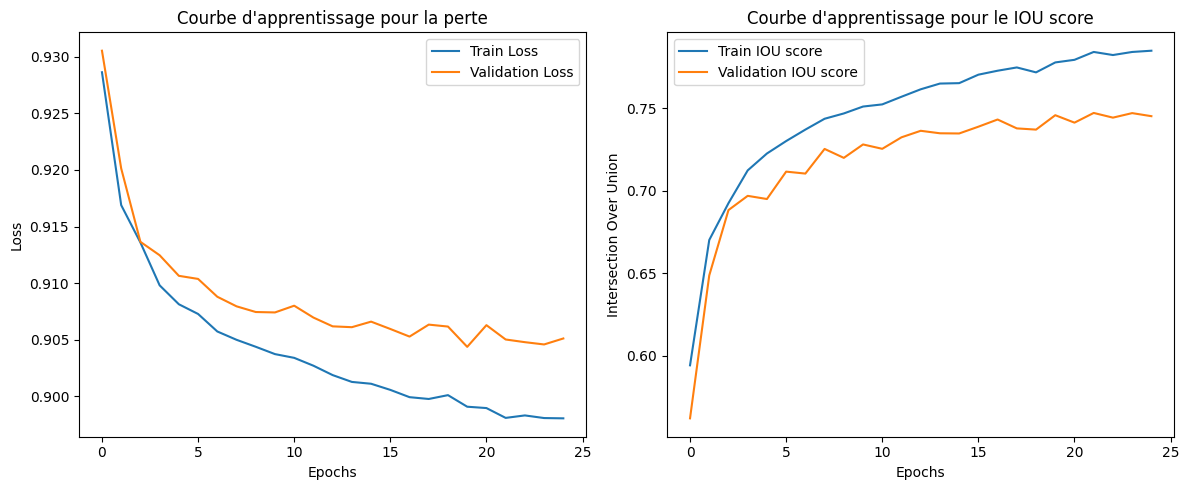

In [7]:
num_epochs = 30
model_name = "_FPN_efficientnetb3_aug"
model = sm.FPN(
    "efficientnetb3",
    input_shape=(256, 256, 3),
    classes=len(train_gen.categories),
    activation="softmax",
)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + model_name
visualize_callback = VisualizeCallback(
    generator=train_gen_aug, model_name=model_name, log_dir=log_dir
)
checkpoint_callback = ModelCheckpoint(
    "saved_model/FPN_efficientnetb3_aug",
    save_best_only=True,
    monitor="val_iou_score",
    mode="max",
)
tensorboard_callback = TensorBoard(log_dir=log_dir, write_graph=True, write_images=True)
early_stopping = EarlyStopping(monitor="val_iou_score", patience=3, mode="max")
model.compile(optimizer="adam", loss=dice_loss, metrics=[jaccard_index, dice_coef])
history = model.fit(
    train_gen_aug,
    epochs=num_epochs,
    validation_data=val_gen,
    callbacks=[
        checkpoint_callback,
        tensorboard_callback,
        early_stopping,
        visualize_callback,
    ],
)
scores = model.evaluate(val_gen, verbose=0)
print("Loss:", scores[0])
print("IOU score:", scores[1])
print("F1 score:", scores[2])
plot_history(history)

Les performances du modèle FPN sont légèrement accrues avec de la data augmentation. 